# UFC Fight Prediction


In [2]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import psycopg2
from config import password
from sqlalchemy import create_engine
import io

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Read in the CSV file (data.csv) as a DataFrame
ufc_df = pd.read_csv("Resources/scraped_data.csv", low_memory=False)
ufc_df

# DtypeWarning: Columns (2,98,122,139,142,146,163,166,259,300,303,307,324,327) have mixed types.
# FIX: To ensure no mixed types either set low_memory=False in read_csv(),
# or specify the type with the dtype parameter. Specifying the datatype may result in memory improvements.


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198,1994-12-16,UFC 4 Tournament Title,No Time Limit,1,Red,SUB,Dan Severn,36,74,250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6199,1994-12-16,Open Weight,No Time Limit,1,Red,SUB,Ron van Clief,51,70,190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6200,1994-09-09,Open Weight,No Time Limit,1,Red,SUB,Kimo Leopoldo,26,75,235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6201,1994-03-11,UFC 2 Tournament Title,No Time Limit,1,Red,KO/TKO,Patrick Smith,30,74,225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning


In [4]:
# View duplicated rows.
display(ufc_df[ufc_df.duplicated()])

# Dropping duplicate rows. Can happen sometimes due to the new event being scraped.
ufc_df = ufc_df.drop_duplicates()
display(ufc_df)

# If the subset of columns contains a duplicate row then Raise SystemExit exception; historically, this has not occurred before.
if len(ufc_df[ufc_df.duplicated(subset=["Event_Date", "B_Name", "R_Name"])]) != 0:
    raise SystemExit("Duplicate events found!")


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198,1994-12-16,UFC 4 Tournament Title,No Time Limit,1,Red,SUB,Dan Severn,36,74,250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6199,1994-12-16,Open Weight,No Time Limit,1,Red,SUB,Ron van Clief,51,70,190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6200,1994-09-09,Open Weight,No Time Limit,1,Red,SUB,Kimo Leopoldo,26,75,235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6201,1994-03-11,UFC 2 Tournament Title,No Time Limit,1,Red,KO/TKO,Patrick Smith,30,74,225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Converting Event_Date column values to datetime64 to drop older fights below
ufc_df["Event_Date"] = pd.to_datetime(ufc_df["Event_Date"])


In [6]:
# Removing old fights due to the lack of rule consistency
ufc_df = ufc_df[ufc_df["Event_Date"] >= pd.to_datetime("5/3/2001")]


In [7]:
# TODO: Fix handling of `--`, `---`, or `No Time Limit`; I was unsure on what each value means so I just set them to NaN.
ufc_df = ufc_df.replace("--", np.NaN)
ufc_df = ufc_df.replace("---", np.NaN)
ufc_df = ufc_df.replace("No Time Limit", np.NaN)


In [8]:
# Extract number inside the parenthesis using Regex matching; no contest(s) amount
ufc_df["R_No_Contest"] = ufc_df["R_Draws"].str.extract("\((\d+)\sNC\)", expand=False)
ufc_df["B_No_Contest"] = ufc_df["B_Draws"].str.extract("\((\d+)\sNC\)", expand=False)

# Extract first number at start of string using Regex matching; draw(s) amount
ufc_df["R_Draws"] = ufc_df["R_Draws"].str.extract("^(\d+)", expand=False)
ufc_df["B_Draws"] = ufc_df["B_Draws"].str.extract("^(\d+)", expand=False)


|   Weight Class    | Minimum Weight (lb) | Maximum Weight (lb) |
| :---------------: | :-----------------: | :-----------------: |
|    Heavyweight    |         205         |         265         |
| Light Heavyweight |         185         |         205         |
|   Middleweight    |         170         |         185         |
|   Welterweight    |         155         |         170         |
|    Lightweight    |         145         |         155         |
|   Featherweight   |         135         |         145         |
|   Bantamweight    |         125         |         135         |
|     Flyweight     |         115         |         125         |
|   Strawweight\*   |          0          |         115         |

- "The women’s UFC division is split into only 4 classes: strawweight, flyweight, bantamweight, and featherweight. The strawweight class is only used in the women’s division and men do not compete in it."


In [9]:
# View descriptive statistics (central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values)
# before removing rows that do not contain a standardized weight class
display(ufc_df[["R_Weight", "B_Weight"]].describe())
display(ufc_df.Weight_Class.value_counts())

# Keep rows that contain standardized weight class
ufc_df = ufc_df.loc[
    (ufc_df.Weight_Class == "Heavyweight")
    | (ufc_df.Weight_Class == "Light Heavyweight")
    | (ufc_df.Weight_Class == "Middleweight")
    | (ufc_df.Weight_Class == "Welterweight")
    | (ufc_df.Weight_Class == "Lightweight")
    | (ufc_df.Weight_Class == "Featherweight")
    | (ufc_df.Weight_Class == "Bantamweight")
    | (ufc_df.Weight_Class == "Flyweight")
    | (ufc_df.Weight_Class == "Strawweight")
    | (ufc_df.Weight_Class == "Women's Strawweight")
    | (ufc_df.Weight_Class == "Women's Flyweight")
    | (ufc_df.Weight_Class == "Women's Bantamweight")
    | (ufc_df.Weight_Class == "Women's Featherweight")
    # TODO: Should "Catch Weight" be excluded?
    # | (ufc_df.Weight_Class == "Catch Weight")
    # | (ufc_df.Weight_Class == "Super Heavyweight")  # no longer a weight class or part of dataset
    # | (ufc_df.Weight_Class == "Open Weight")  # no longer a weight class or part of dataset
    # TODO: Create `other` category for anything that does not fall in standardized Weight_Class (?)
    # | (ufc_df.Winnner == "Other")
]

# View descriptive statistics (central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values)
# after removing rows that do not contain a standardized weight class
display("-" * 50)
display(ufc_df[["R_Weight", "B_Weight"]].describe())
display(ufc_df.Weight_Class.value_counts())



,R_Weight,B_Weight
count,6100.000000,6100.000000
mean,168.194098,167.780328
std,34.752299,34.561815
min,115.000000,115.000000
25%,145.000000,145.000000
50%,170.000000,168.000000
75%,185.000000,185.000000
max,265.000000,265.000000


Lightweight                                                       1054
Welterweight                                                      1049
Middleweight                                                       779
Featherweight                                                      575
Light Heavyweight                                                  534
                                                                  ... 
TUF Nations Canada vs. Australia Middleweight Tournament Title       1
TUF Nations Canada vs. Australia Welterweight Tournament Title       1
Ultimate Fighter China Welterweight Tournament Title                 1
Ultimate Fighter 18 Women's Bantamweight Tournament Title            1
Ultimate Fighter 1 Middleweight Tournament Title                     1
Name: Weight_Class, Length: 87, dtype: int64

'--------------------------------------------------'

,R_Weight,B_Weight
count,5719.000000,5719.000000
mean,168.053856,167.633153
std,34.551469,34.318907
min,115.000000,115.000000
25%,145.000000,145.000000
50%,170.000000,155.000000
75%,185.000000,185.000000
max,265.000000,265.000000


Lightweight              1054
Welterweight             1049
Middleweight              779
Featherweight             575
Light Heavyweight         534
Heavyweight               496
Bantamweight              495
Flyweight                 230
Women's Strawweight       204
Women's Bantamweight      146
Women's Flyweight         144
Women's Featherweight      13
Name: Weight_Class, dtype: int64

In [10]:
# NEW COLUMN ORDER
new_column_order = [
    "Event_Date",
    "Weight_Class",
    "Max_Rounds",
    "Ending_Round",
    "Winner",
    "Win_By",
    "B_Name",
    "B_Age",
    "B_Height",
    "B_Weight",
    "B_Reach",
    "B_Stance",
    "B_Wins",
    "B_Losses",
    "B_Draws",
    "B_No_Contest",
    "B_Career_Significant_Strikes_Absorbed_PM",
    "B_Career_Significant_Strikes_Landed_PM",
    "B_Career_Striking_Accuracy",
    "B_Career_Significant_Strike_Defence",
    "B_Career_Takedown_Average",
    "B_Career_Takedown_Accuracy",
    "B_Career_Takedown_Defence",
    "B_Career_Submission_Average",
    "B_Knockdowns",
    "B_Significant_Strikes_Landed",
    "B_Significant_Strikes_Attempted",
    "B_Significant_Strike_Perc",
    "B_Significant_Strikes_Distance_Landed",
    "B_Significant_Strikes_Distance_Attempted",
    "B_Significant_Strikes_Clinch_Landed",
    "B_Significant_Strikes_Clinch_Attempted",
    "B_Significant_Strikes_Ground_Landed",
    "B_Significant_Strikes_Ground_Attempted",
    "B_Head_Significant_Strikes_Attempted",
    "B_Head_Significant_Strikes_Landed",
    "B_Body_Significant_Strikes_Attempted",
    "B_Body_Significant_Strikes_Landed",
    "B_Leg_Significant_Strikes_Attempted",
    "B_Leg_Significant_Strikes_Landed",
    "B_Total_Strikes_Attempted",
    "B_Total_Strikes_Landed",
    "B_Takedowns_Attempted",
    "B_Takedowns_Landed",
    "B_Takedown_Perc",
    "B_Submission_Attempts",
    "B_Grappling_Reversals",
    "B_Grappling_Control_Time",
    "B_Round_One_Knockdowns",
    "B_Round_One_Significant_Strikes_Landed",
    "B_Round_One_Significant_Strikes_Attempted",
    "B_Round_One_Significant_Strike_Perc",
    "B_Round_One_Significant_Strikes_Distance_Landed",
    "B_Round_One_Significant_Strikes_Distance_Attempted",
    "B_Round_One_Significant_Strikes_Clinch_Landed",
    "B_Round_One_Significant_Strikes_Clinch_Attempted",
    "B_Round_One_Significant_Strikes_Ground_Landed",
    "B_Round_One_Significant_Strikes_Ground_Attempted",
    "B_Round_One_Head_Significant_Strikes_Attempted",
    "B_Round_One_Head_Significant_Strikes_Landed",
    "B_Round_One_Body_Significant_Strikes_Attempted",
    "B_Round_One_Body_Significant_Strikes_Landed",
    "B_Round_One_Leg_Significant_Strikes_Attempted",
    "B_Round_One_Leg_Significant_Strikes_Landed",
    "B_Round_One_Total_Strikes_Attempted",
    "B_Round_One_Total_Strikes_Landed",
    "B_Round_One_Takedowns_Attempted",
    "B_Round_One_Takedowns_Landed",
    "B_Round_One_Takedown_Perc",
    "B_Round_One_Submission_Attempts",
    "B_Round_One_Grappling_Reversals",
    "B_Round_One_Grappling_Control_Time",
    "B_Round_Two_Knockdowns",
    "B_Round_Two_Significant_Strikes_Landed",
    "B_Round_Two_Significant_Strikes_Attempted",
    "B_Round_Two_Significant_Strike_Perc",
    "B_Round_Two_Significant_Strikes_Distance_Landed",
    "B_Round_Two_Significant_Strikes_Distance_Attempted",
    "B_Round_Two_Significant_Strikes_Clinch_Landed",
    "B_Round_Two_Significant_Strikes_Clinch_Attempted",
    "B_Round_Two_Significant_Strikes_Ground_Landed",
    "B_Round_Two_Significant_Strikes_Ground_Attempted",
    "B_Round_Two_Head_Significant_Strikes_Attempted",
    "B_Round_Two_Head_Significant_Strikes_Landed",
    "B_Round_Two_Body_Significant_Strikes_Attempted",
    "B_Round_Two_Body_Significant_Strikes_Landed",
    "B_Round_Two_Leg_Significant_Strikes_Attempted",
    "B_Round_Two_Leg_Significant_Strikes_Landed",
    "B_Round_Two_Total_Strikes_Attempted",
    "B_Round_Two_Total_Strikes_Landed",
    "B_Round_Two_Takedowns_Attempted",
    "B_Round_Two_Takedowns_Landed",
    "B_Round_Two_Takedown_Perc",
    "B_Round_Two_Submission_Attempts",
    "B_Round_Two_Grappling_Reversals",
    "B_Round_Two_Grappling_Control_Time",
    "B_Round_Three_Knockdowns",
    "B_Round_Three_Significant_Strikes_Landed",
    "B_Round_Three_Significant_Strikes_Attempted",
    "B_Round_Three_Significant_Strike_Perc",
    "B_Round_Three_Significant_Strikes_Distance_Landed",
    "B_Round_Three_Significant_Strikes_Distance_Attempted",
    "B_Round_Three_Significant_Strikes_Clinch_Landed",
    "B_Round_Three_Significant_Strikes_Clinch_Attempted",
    "B_Round_Three_Significant_Strikes_Ground_Landed",
    "B_Round_Three_Significant_Strikes_Ground_Attempted",
    "B_Round_Three_Head_Significant_Strikes_Attempted",
    "B_Round_Three_Head_Significant_Strikes_Landed",
    "B_Round_Three_Body_Significant_Strikes_Attempted",
    "B_Round_Three_Body_Significant_Strikes_Landed",
    "B_Round_Three_Leg_Significant_Strikes_Attempted",
    "B_Round_Three_Leg_Significant_Strikes_Landed",
    "B_Round_Three_Total_Strikes_Attempted",
    "B_Round_Three_Total_Strikes_Landed",
    "B_Round_Three_Takedowns_Attempted",
    "B_Round_Three_Takedowns_Landed",
    "B_Round_Three_Takedown_Perc",
    "B_Round_Three_Submission_Attempts",
    "B_Round_Three_Grappling_Reversals",
    "B_Round_Three_Grappling_Control_Time",
    "B_Round_Four_Knockdowns",
    "B_Round_Four_Significant_Strikes_Landed",
    "B_Round_Four_Significant_Strikes_Attempted",
    "B_Round_Four_Significant_Strike_Perc",
    "B_Round_Four_Significant_Strikes_Distance_Landed",
    "B_Round_Four_Significant_Strikes_Distance_Attempted",
    "B_Round_Four_Significant_Strikes_Clinch_Landed",
    "B_Round_Four_Significant_Strikes_Clinch_Attempted",
    "B_Round_Four_Significant_Strikes_Ground_Landed",
    "B_Round_Four_Significant_Strikes_Ground_Attempted",
    "B_Round_Four_Head_Significant_Strikes_Attempted",
    "B_Round_Four_Head_Significant_Strikes_Landed",
    "B_Round_Four_Body_Significant_Strikes_Attempted",
    "B_Round_Four_Body_Significant_Strikes_Landed",
    "B_Round_Four_Leg_Significant_Strikes_Attempted",
    "B_Round_Four_Leg_Significant_Strikes_Landed",
    "B_Round_Four_Total_Strikes_Attempted",
    "B_Round_Four_Total_Strikes_Landed",
    "B_Round_Four_Takedowns_Attempted",
    "B_Round_Four_Takedowns_Landed",
    "B_Round_Four_Takedown_Perc",
    "B_Round_Four_Submission_Attempts",
    "B_Round_Four_Grappling_Reversals",
    "B_Round_Four_Grappling_Control_Time",
    "B_Round_Five_Knockdowns",
    "B_Round_Five_Significant_Strikes_Landed",
    "B_Round_Five_Significant_Strikes_Attempted",
    "B_Round_Five_Significant_Strike_Perc",
    "B_Round_Five_Significant_Strikes_Distance_Landed",
    "B_Round_Five_Significant_Strikes_Distance_Attempted",
    "B_Round_Five_Significant_Strikes_Clinch_Landed",
    "B_Round_Five_Significant_Strikes_Clinch_Attempted",
    "B_Round_Five_Significant_Strikes_Ground_Landed",
    "B_Round_Five_Significant_Strikes_Ground_Attempted",
    "B_Round_Five_Head_Significant_Strikes_Attempted",
    "B_Round_Five_Head_Significant_Strikes_Landed",
    "B_Round_Five_Body_Significant_Strikes_Attempted",
    "B_Round_Five_Body_Significant_Strikes_Landed",
    "B_Round_Five_Leg_Significant_Strikes_Attempted",
    "B_Round_Five_Leg_Significant_Strikes_Landed",
    "B_Round_Five_Total_Strikes_Attempted",
    "B_Round_Five_Total_Strikes_Landed",
    "B_Round_Five_Takedowns_Attempted",
    "B_Round_Five_Takedowns_Landed",
    "B_Round_Five_Takedown_Perc",
    "B_Round_Five_Submission_Attempts",
    "B_Round_Five_Grappling_Reversals",
    "B_Round_Five_Grappling_Control_Time",
    "R_Name",
    "R_Age",
    "R_Height",
    "R_Weight",
    "R_Reach",
    "R_Stance",
    "R_Wins",
    "R_Losses",
    "R_Draws",
    "R_No_Contest",
    "R_Career_Significant_Strikes_Absorbed_PM",
    "R_Career_Significant_Strikes_Landed_PM",
    "R_Career_Striking_Accuracy",
    "R_Career_Significant_Strike_Defence",
    "R_Career_Takedown_Average",
    "R_Career_Takedown_Accuracy",
    "R_Career_Takedown_Defence",
    "R_Career_Submission_Average",
    "R_Knockdowns",
    "R_Significant_Strikes_Landed",
    "R_Significant_Strikes_Attempted",
    "R_Significant_Strike_Perc",
    "R_Significant_Strikes_Distance_Landed",
    "R_Significant_Strikes_Distance_Attempted",
    "R_Significant_Strikes_Clinch_Landed",
    "R_Significant_Strikes_Clinch_Attempted",
    "R_Significant_Strikes_Ground_Landed",
    "R_Significant_Strikes_Ground_Attempted",
    "R_Head_Significant_Strikes_Attempted",
    "R_Head_Significant_Strikes_Landed",
    "R_Body_Significant_Strikes_Attempted",
    "R_Body_Significant_Strikes_Landed",
    "R_Leg_Significant_Strikes_Attempted",
    "R_Leg_Significant_Strikes_Landed",
    "R_Total_Strikes_Attempted",
    "R_Total_Strikes_Landed",
    "R_Takedowns_Attempted",
    "R_Takedowns_Landed",
    "R_Takedown_Perc",
    "R_Submission_Attempts",
    "R_Grappling_Reversals",
    "R_Grappling_Control_Time",
    "R_Round_One_Knockdowns",
    "R_Round_One_Significant_Strikes_Landed",
    "R_Round_One_Significant_Strikes_Attempted",
    "R_Round_One_Significant_Strike_Perc",
    "R_Round_One_Significant_Strikes_Distance_Attempted",
    "R_Round_One_Significant_Strikes_Distance_Landed",
    "R_Round_One_Significant_Strikes_Clinch_Attempted",
    "R_Round_One_Significant_Strikes_Clinch_Landed",
    "R_Round_One_Significant_Strikes_Ground_Attempted",
    "R_Round_One_Significant_Strikes_Ground_Landed",
    "R_Round_One_Head_Significant_Strikes_Attempted",
    "R_Round_One_Head_Significant_Strikes_Landed",
    "R_Round_One_Body_Significant_Strikes_Attempted",
    "R_Round_One_Body_Significant_Strikes_Landed",
    "R_Round_One_Leg_Significant_Strikes_Attempted",
    "R_Round_One_Leg_Significant_Strikes_Landed",
    "R_Round_One_Total_Strikes_Attempted",
    "R_Round_One_Total_Strikes_Landed",
    "R_Round_One_Takedowns_Attempted",
    "R_Round_One_Takedowns_Landed",
    "R_Round_One_Takedown_Perc",
    "R_Round_One_Submission_Attempts",
    "R_Round_One_Grappling_Reversals",
    "R_Round_One_Grappling_Control_Time",
    "R_Round_Two_Knockdowns",
    "R_Round_Two_Significant_Strikes_Landed",
    "R_Round_Two_Significant_Strikes_Attempted",
    "R_Round_Two_Significant_Strike_Perc",
    "R_Round_Two_Significant_Strikes_Distance_Attempted",
    "R_Round_Two_Significant_Strikes_Distance_Landed",
    "R_Round_Two_Significant_Strikes_Clinch_Attempted",
    "R_Round_Two_Significant_Strikes_Clinch_Landed",
    "R_Round_Two_Significant_Strikes_Ground_Attempted",
    "R_Round_Two_Significant_Strikes_Ground_Landed",
    "R_Round_Two_Head_Significant_Strikes_Attempted",
    "R_Round_Two_Head_Significant_Strikes_Landed",
    "R_Round_Two_Body_Significant_Strikes_Attempted",
    "R_Round_Two_Body_Significant_Strikes_Landed",
    "R_Round_Two_Leg_Significant_Strikes_Attempted",
    "R_Round_Two_Leg_Significant_Strikes_Landed",
    "R_Round_Two_Total_Strikes_Attempted",
    "R_Round_Two_Total_Strikes_Landed",
    "R_Round_Two_Takedowns_Attempted",
    "R_Round_Two_Takedowns_Landed",
    "R_Round_Two_Takedown_Perc",
    "R_Round_Two_Submission_Attempts",
    "R_Round_Two_Grappling_Reversals",
    "R_Round_Two_Grappling_Control_Time",
    "R_Round_Three_Knockdowns",
    "R_Round_Three_Significant_Strikes_Landed",
    "R_Round_Three_Significant_Strikes_Attempted",
    "R_Round_Three_Significant_Strike_Perc",
    "R_Round_Three_Significant_Strikes_Distance_Attempted",
    "R_Round_Three_Significant_Strikes_Distance_Landed",
    "R_Round_Three_Significant_Strikes_Clinch_Attempted",
    "R_Round_Three_Significant_Strikes_Clinch_Landed",
    "R_Round_Three_Significant_Strikes_Ground_Attempted",
    "R_Round_Three_Significant_Strikes_Ground_Landed",
    "R_Round_Three_Head_Significant_Strikes_Attempted",
    "R_Round_Three_Head_Significant_Strikes_Landed",
    "R_Round_Three_Body_Significant_Strikes_Attempted",
    "R_Round_Three_Body_Significant_Strikes_Landed",
    "R_Round_Three_Leg_Significant_Strikes_Attempted",
    "R_Round_Three_Leg_Significant_Strikes_Landed",
    "R_Round_Three_Total_Strikes_Attempted",
    "R_Round_Three_Total_Strikes_Landed",
    "R_Round_Three_Takedowns_Attempted",
    "R_Round_Three_Takedowns_Landed",
    "R_Round_Three_Takedown_Perc",
    "R_Round_Three_Submission_Attempts",
    "R_Round_Three_Grappling_Reversals",
    "R_Round_Three_Grappling_Control_Time",
    "R_Round_Four_Knockdowns",
    "R_Round_Four_Significant_Strikes_Landed",
    "R_Round_Four_Significant_Strikes_Attempted",
    "R_Round_Four_Significant_Strike_Perc",
    "R_Round_Four_Significant_Strikes_Distance_Attempted",
    "R_Round_Four_Significant_Strikes_Distance_Landed",
    "R_Round_Four_Significant_Strikes_Clinch_Attempted",
    "R_Round_Four_Significant_Strikes_Clinch_Landed",
    "R_Round_Four_Significant_Strikes_Ground_Attempted",
    "R_Round_Four_Significant_Strikes_Ground_Landed",
    "R_Round_Four_Head_Significant_Strikes_Attempted",
    "R_Round_Four_Head_Significant_Strikes_Landed",
    "R_Round_Four_Body_Significant_Strikes_Attempted",
    "R_Round_Four_Body_Significant_Strikes_Landed",
    "R_Round_Four_Leg_Significant_Strikes_Attempted",
    "R_Round_Four_Leg_Significant_Strikes_Landed",
    "R_Round_Four_Total_Strikes_Attempted",
    "R_Round_Four_Total_Strikes_Landed",
    "R_Round_Four_Takedowns_Attempted",
    "R_Round_Four_Takedowns_Landed",
    "R_Round_Four_Takedown_Perc",
    "R_Round_Four_Submission_Attempts",
    "R_Round_Four_Grappling_Reversals",
    "R_Round_Four_Grappling_Control_Time",
    "R_Round_Five_Knockdowns",
    "R_Round_Five_Significant_Strikes_Landed",
    "R_Round_Five_Significant_Strikes_Attempted",
    "R_Round_Five_Significant_Strike_Perc",
    "R_Round_Five_Significant_Strikes_Distance_Attempted",
    "R_Round_Five_Significant_Strikes_Distance_Landed",
    "R_Round_Five_Significant_Strikes_Clinch_Attempted",
    "R_Round_Five_Significant_Strikes_Clinch_Landed",
    "R_Round_Five_Significant_Strikes_Ground_Attempted",
    "R_Round_Five_Significant_Strikes_Ground_Landed",
    "R_Round_Five_Head_Significant_Strikes_Attempted",
    "R_Round_Five_Head_Significant_Strikes_Landed",
    "R_Round_Five_Body_Significant_Strikes_Attempted",
    "R_Round_Five_Body_Significant_Strikes_Landed",
    "R_Round_Five_Leg_Significant_Strikes_Attempted",
    "R_Round_Five_Leg_Significant_Strikes_Landed",
    "R_Round_Five_Total_Strikes_Attempted",
    "R_Round_Five_Total_Strikes_Landed",
    "R_Round_Five_Takedowns_Attempted",
    "R_Round_Five_Takedowns_Landed",
    "R_Round_Five_Takedown_Perc",
    "R_Round_Five_Submission_Attempts",
    "R_Round_Five_Grappling_Reversals",
    "R_Round_Five_Grappling_Control_Time",
]

# TODO: Should we alphabetize sort the columns instead of hardcoding?
# np.sort(ufc_df.columns.tolist())


In [11]:
# Symmetric difference between old & new columns to ensure columns are not missing.
set(ufc_df.columns.tolist()) ^ set(new_column_order)


set()

In [12]:
ufc_df = ufc_df.reindex(columns=new_column_order)


In [13]:
#  Infer best column dtype & add missing values to rows
ufc_df = ufc_df.convert_dtypes()
ufc_df.dtypes.value_counts()


Int64             272
string             49
Float64             8
datetime64[ns]      1
dtype: int64

In [14]:
ufc_df.head()


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Data Exploration


### Winner (Red vs. Blue)


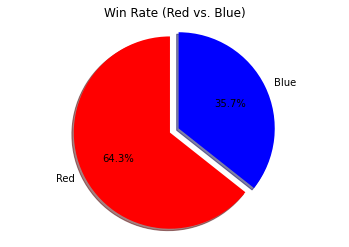

In [15]:
# Pie chart, Red vs. Blue win rate
pie_labels = ufc_df["Winner"].value_counts().index
pie_values = ufc_df["Winner"].value_counts().values
explode = (0, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()

ax1.pie(
    x=pie_values,
    labels=pie_labels,
    colors=["red", "blue"],
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axes.set_title("Win Rate (Red vs. Blue)")

plt.show()


### Age


In [16]:
# Generate descriptive statistics on Age columns (min, max, etc)
ufc_df[["R_Age", "B_Age"]].describe()


,R_Age,B_Age
count,5719.000000,5719.000000
mean,29.756251,29.346739
std,4.187462,4.006322
min,19.000000,18.000000
25%,27.000000,26.000000
50%,30.000000,29.000000
75%,32.000000,32.000000
max,47.000000,47.000000


<AxesSubplot:>

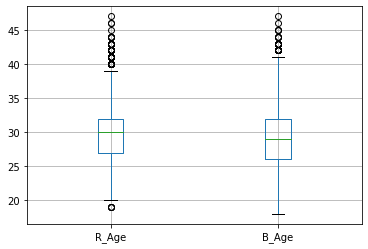

In [17]:
# Use Box & Whisker plot to visualize Age outliers
ufc_df.boxplot(column=["R_Age", "B_Age"])


### Height


In [18]:
# Generate descriptive statistics on Height columns (min, max, etc)
ufc_df[["R_Height", "B_Height"]].describe()


,R_Height,B_Height
count,5719.000000,5719.000000
mean,70.338870,70.331177
std,3.496745,3.443309
min,60.000000,60.000000
25%,68.000000,68.000000
50%,70.000000,70.000000
75%,73.000000,73.000000
max,83.000000,83.000000


<AxesSubplot:>

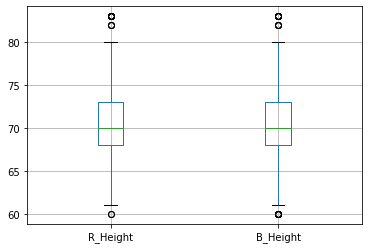

In [19]:
# Use Box & Whisker plot to visualize Height outliers
ufc_df.boxplot(column=["R_Height", "B_Height"])


### Weight


In [20]:
# Generate descriptive statistics on Weight columns (min, max, etc)
ufc_df[["R_Weight", "B_Weight"]].describe()


,R_Weight,B_Weight
count,5719.000000,5719.000000
mean,168.053856,167.633153
std,34.551469,34.318907
min,115.000000,115.000000
25%,145.000000,145.000000
50%,170.000000,155.000000
75%,185.000000,185.000000
max,265.000000,265.000000


<AxesSubplot:>

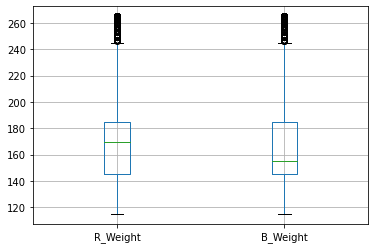

In [21]:
# Use Box & Whisker plot to visualize Weight outliers
ufc_df.boxplot(column=["R_Weight", "B_Weight"])


## Feature Engineering


### Feature Creation


#### Age Bucket


In [22]:
# Create four equal-sized buckets for the Age columns based on sample quantiles

ufc_df["R_Age_Bucket"] = pd.qcut(
    x=ufc_df["R_Age"], q=4, labels=None, retbins=False, precision=3
)


ufc_df["B_Age_Bucket"] = pd.qcut(
    x=ufc_df["B_Age"], q=4, labels=None, retbins=False, precision=3
)


# Drop age columns
# ufc_df = ufc_df.drop(columns=["R_Age", "B_Age"])


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


<AxesSubplot:title={'center':'Red Age Buckets'}>

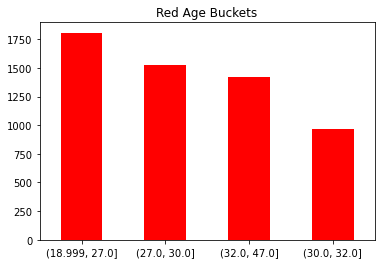

In [23]:
# Create a bar graph to visualize R_Age_Bucket
ufc_df["R_Age_Bucket"].value_counts().plot(
    kind="bar", color="red", rot=0, title="Red Age Buckets"
)


<AxesSubplot:title={'center':'Blue Age Buckets'}>

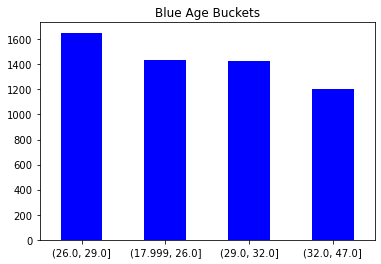

In [24]:
# Create a bar graph to visualize B_Age_Bucket
ufc_df["B_Age_Bucket"].value_counts().plot(
    kind="bar", color="blue", rot=0, title="Blue Age Buckets"
)


#### Height Bucket


In [25]:
# Create four equal-sized buckets for the Height columns based on sample quantiles

ufc_df["R_Height_Bucket"] = pd.qcut(
    x=ufc_df["R_Height"], q=4, labels=None, retbins=False, precision=3
)

ufc_df["B_Height_Bucket"] = pd.qcut(
    x=ufc_df["B_Height"], q=4, labels=None, retbins=False, precision=3
)

# Drop height columns
# ufc_df = ufc_df.drop(columns=["R_Height", "B_Height"])


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


<AxesSubplot:title={'center':'Red Height Buckets'}>

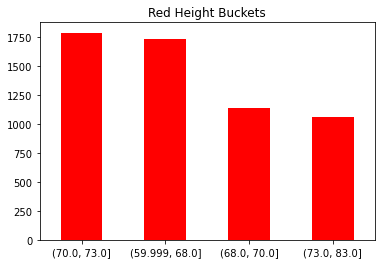

In [26]:
# Create a bar graph to visualize R_Height_Bucket
ufc_df["R_Height_Bucket"].value_counts().plot(
    kind="bar", color="red", rot=0, title="Red Height Buckets"
)


<AxesSubplot:title={'center':'Blue Height Buckets'}>

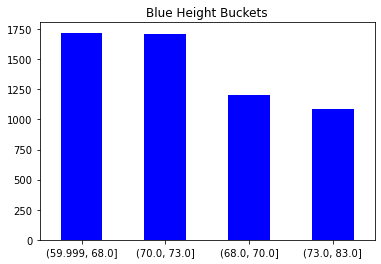

In [27]:
# Create a bar graph to visualize B_Height_Bucket
ufc_df["B_Height_Bucket"].value_counts().plot(
    kind="bar", color="blue", rot=0, title="Blue Height Buckets"
)


#### Gender


In [28]:
# Create Gender Fight Class Column

# TODO: There might be a *better* way of determining Gender, but this seems to works.
# ufc_df["Gender"] = np.where(
#     ufc_df["Weight_Class"].str.contains("Women's"), "Female", "Male"
# )

ufc_df["Gender"] = np.where(
    ufc_df["Weight_Class"].str.contains("Women's"), 0, 1
)  # Gender (sex) is 0 if female and 1 if male.


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [29]:
# display(
#     ufc_df.loc[
#         (ufc_df.Weight_Class == "Women's Strawweight")
#         | (ufc_df.Weight_Class == "Women's Flyweight")
#         | (ufc_df.Weight_Class == "Women's Bantamweight")
#         | (ufc_df.Weight_Class == "Women's Featherweight")
#     ].shape[0]
# )

ufc_df["Gender"].value_counts()


1    5212
0     507
Name: Gender, dtype: int64

#### Body Mass Index (BMI)


[Calculating BMI Using the English System](https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_2.html)

Formula:

> **weight** (lb) / [**height** (in)]<sup>2</sup> \* **703**


> "The normal BMI scores may not be accurate if you're very muscular because muscle can add extra kilos, resulting in a high BMI when you're not an unhealthy weight." ([National Health Service](https://www.nhs.uk/conditions/obesity/diagnosis/))


In [30]:
# Divide weight by height twice, multiply by 703, and round to one decimal place

# Calculate Red fighter BMI
ufc_df["R_BMI"] = round(ufc_df["R_Weight"] / ufc_df["R_Height"] ** 2 * 703, 1)

# Calculate Blue fighter BMI
ufc_df["B_BMI"] = round(ufc_df["B_Weight"] / ufc_df["B_Height"] ** 2 * 703, 1)


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


#### Proposed new BMI


[Proposed formula](https://web.archive.org/web/20220321050055/https://people.maths.ox.ac.uk/trefethen/bmi.html) by Nick Trefethen, Professor of numerical analysis at University of Oxford.

New formula:

> **5734** \* **weight** (lb) / [**height** (in)]<sup>2.5</sup>


In [31]:
# Calculate BMI with the new proposed formula.

# Calculate Red fighter BMI under proposed BMI
ufc_df["R_BMI_proposed"] = round(
    5734 * ufc_df["R_Weight"] / ufc_df["R_Height"] ** 2.5, 1
)

# Calculate Blue fighter BMI under proposed BMI
ufc_df["B_BMI_proposed"] = round(
    5734 * ufc_df["B_Weight"] / ufc_df["B_Height"] ** 2.5, 1
)


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


#### Estimation of Body Fat


Adult Body Fat Percentage

Formula:

> Body fat % = (1.39 \* BMI) + (0.16 \* Age) - (10.34 \* Gender) - 9)

- Where gender (sex) is 0 if female and 1 if male to account for the lower body fat percentage of men (International Journal of Obesity and Related Metabolic Disorders in 2002)


In [32]:
# Estimate Red Fighter Body Fat Percentage
ufc_df["R_Body_Fat_Percentage"] = (1.39 * ufc_df["R_BMI"]) + (0.16 * ufc_df["R_Age"] - (10.34 * ufc_df["Gender"]) - 9)

# Estimate Blue Fighter Body Fat Percentage
ufc_df["B_Body_Fat_Percentage"] = (1.39 * ufc_df["R_BMI"]) + (0.16 * ufc_df["R_Age"] - (10.34 * ufc_df["Gender"]) - 9)


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


#### Lean Body Mass


"For calculating lean body mass, body fat percentage was subtracted from 100 to get the lean mass percentage and lean mass percentage was divided by 100 to calculate the decimal for lean mass percentage, and then lean mass decimal was multiplied with total body weight." [(Prakash KO, Choudhary R, Singh G. Lean body mass, body fat percentage, and handgrip strength as predictors of bone mineral density in postmenopausal women. J Mid-life Health 2021;12:299-303)](https://www.jmidlifehealth.org/text.asp?2021/12/4/299/336149)

Formula(s):

> Lean Mass Percentage = 100 - Body Fat Percentage

> Lean Mass Decimal = Lean Mass Percentage / 100

> Lean Body Mass = Lean Mass Decimal \* Total Body Weight

> Lean Body Mass = ((100 - Body Fat Percentage) / 100) \* Total Body Weight


In [33]:
# Estimate Red Fighter Lean Body Mass
ufc_df["R_Lean_Body_Mass"] = ((100 - ufc_df["R_Body_Fat_Percentage"]) / 100) * ufc_df["R_Weight"]

# Estimate Blue Fighter Lean Body Mass
ufc_df["B_Lean_Body_Mass"] = ((100 - ufc_df["B_Body_Fat_Percentage"]) / 100) * ufc_df["B_Weight"]


/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


### Set Categories


In [34]:
# Convert `winby` column into a category dtype
ufc_df["Win_By"] = ufc_df["Win_By"].astype("category")

# Convert stances column into a category dtype
ufc_df["R_Stance"] = ufc_df["R_Stance"].astype("category")
ufc_df["B_Stance"] = ufc_df["B_Stance"].astype("category")

# Convert Weight_Class column into a category dtype
ufc_df["Weight_Class"] = ufc_df["Weight_Class"].astype("category")

# Convert Gender column into a category dtype
ufc_df["Gender"] = ufc_df["Gender"].astype("category")
ufc_df["Gender"] = ufc_df["Gender"].cat.rename_categories({0: "Female", 1: "Male"})


### View Features


In [35]:
# View category dtypes
ufc_df.select_dtypes(include=["category"]).columns.tolist()


['Weight_Class',
 'Win_By',
 'B_Stance',
 'R_Stance',
 'R_Age_Bucket',
 'B_Age_Bucket',
 'R_Height_Bucket',
 'B_Height_Bucket',
 'Gender']

In [36]:
# View numerical values
ufc_df.select_dtypes(include=["number"]).columns.tolist()


['Ending_Round',
 'B_Age',
 'B_Height',
 'B_Weight',
 'B_Wins',
 'B_Losses',
 'B_Career_Significant_Strikes_Absorbed_PM',
 'B_Career_Significant_Strikes_Landed_PM',
 'B_Career_Striking_Accuracy',
 'B_Career_Significant_Strike_Defence',
 'B_Career_Takedown_Average',
 'B_Career_Takedown_Accuracy',
 'B_Career_Takedown_Defence',
 'B_Career_Submission_Average',
 'B_Knockdowns',
 'B_Significant_Strikes_Landed',
 'B_Significant_Strikes_Attempted',
 'B_Significant_Strikes_Distance_Landed',
 'B_Significant_Strikes_Distance_Attempted',
 'B_Significant_Strikes_Clinch_Landed',
 'B_Significant_Strikes_Clinch_Attempted',
 'B_Significant_Strikes_Ground_Landed',
 'B_Significant_Strikes_Ground_Attempted',
 'B_Head_Significant_Strikes_Attempted',
 'B_Head_Significant_Strikes_Landed',
 'B_Body_Significant_Strikes_Attempted',
 'B_Body_Significant_Strikes_Landed',
 'B_Leg_Significant_Strikes_Attempted',
 'B_Leg_Significant_Strikes_Landed',
 'B_Total_Strikes_Attempted',
 'B_Total_Strikes_Landed',
 'B_Takedo

In [37]:
# TODO: Evaluate why some of these columns are inferred as strings
display(ufc_df.select_dtypes(include=["string"]).columns.tolist())

# TODO: Evaluate why some of these columns are inferred as object
display(ufc_df.select_dtypes(include=["object"]).columns.tolist())


['Max_Rounds',
 'Winner',
 'B_Name',
 'B_Reach',
 'B_Draws',
 'B_No_Contest',
 'B_Significant_Strike_Perc',
 'B_Takedown_Perc',
 'B_Grappling_Control_Time',
 'B_Round_One_Significant_Strike_Perc',
 'B_Round_One_Takedown_Perc',
 'B_Round_One_Grappling_Control_Time',
 'B_Round_Two_Significant_Strike_Perc',
 'B_Round_Two_Takedown_Perc',
 'B_Round_Two_Grappling_Control_Time',
 'B_Round_Three_Significant_Strike_Perc',
 'B_Round_Three_Takedown_Perc',
 'B_Round_Three_Grappling_Control_Time',
 'B_Round_Four_Significant_Strike_Perc',
 'B_Round_Four_Takedown_Perc',
 'B_Round_Four_Grappling_Control_Time',
 'B_Round_Five_Significant_Strike_Perc',
 'B_Round_Five_Takedown_Perc',
 'B_Round_Five_Grappling_Control_Time',
 'R_Name',
 'R_Reach',
 'R_Draws',
 'R_No_Contest',
 'R_Significant_Strike_Perc',
 'R_Takedown_Perc',
 'R_Grappling_Control_Time',
 'R_Round_One_Significant_Strike_Perc',
 'R_Round_One_Takedown_Perc',
 'R_Round_One_Grappling_Control_Time',
 'R_Round_Two_Significant_Strike_Perc',
 'R_Ro

[]

In [38]:
# Converting blue corner values to the correct dtype (Categorical or numeric)
ufc_df = ufc_df.astype(
    {
        "B_Reach": "float",
        "B_Name": "category",
        "B_Significant_Strike_Perc": "float",
        "B_Takedown_Perc": "float",
        "B_Round_One_Significant_Strike_Perc": "float",
        "B_Round_One_Takedown_Perc": "float",
        "B_Round_Two_Significant_Strike_Perc": "float",
        "B_Round_Two_Takedown_Perc": "float",
        "B_Round_Three_Significant_Strike_Perc": "float",
        "B_Round_Three_Takedown_Perc": "float",
        "B_Round_Four_Takedown_Perc": "float",
        "B_Round_Five_Takedown_Perc": "float",
        "B_Round_Four_Significant_Strike_Perc": "float",
        "B_Round_Five_Significant_Strike_Perc": "float",
        "B_Draws": "float",
        "B_No_Contest": "float",
    }
)


In [39]:
# Converting red corner values to the correct dtype (Categorical or numeric)
ufc_df = ufc_df.astype(
    {
        "R_Name": "category",
        "R_Reach": "float",
        "R_Significant_Strike_Perc": "float",
        "R_Takedown_Perc": "float",
        "R_Round_One_Significant_Strike_Perc": "float",
        "R_Round_One_Takedown_Perc": "float",
        "R_Round_Two_Significant_Strike_Perc": "float",
        "R_Round_Two_Takedown_Perc": "float",
        "R_Round_Three_Significant_Strike_Perc": "float",
        "R_Round_Three_Takedown_Perc": "float",
        "R_Round_Four_Takedown_Perc": "float",
        "R_Round_Five_Takedown_Perc": "float",
        "R_Round_Five_Significant_Strike_Perc": "float",
        "R_Draws": "float",
        "R_No_Contest": "float",
    }
)


In [40]:
# Convert Max_Rounds to Integer
ufc_df["Max_Rounds"] = ufc_df["Max_Rounds"].astype("Int64")


In [41]:
# TODO: Convert time to correct datatype
display(ufc_df.select_dtypes(include=["string"]).columns.tolist())


['Winner',
 'B_Grappling_Control_Time',
 'B_Round_One_Grappling_Control_Time',
 'B_Round_Two_Grappling_Control_Time',
 'B_Round_Three_Grappling_Control_Time',
 'B_Round_Four_Grappling_Control_Time',
 'B_Round_Five_Grappling_Control_Time',
 'R_Grappling_Control_Time',
 'R_Round_One_Grappling_Control_Time',
 'R_Round_Two_Grappling_Control_Time',
 'R_Round_Three_Grappling_Control_Time',
 'R_Round_Four_Grappling_Control_Time',
 'R_Round_Five_Grappling_Control_Time']

In [42]:
ufc_df.head()

,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,B_Height_Bucket,Gender,R_BMI,B_BMI,R_BMI_proposed,B_BMI_proposed,R_Body_Fat_Percentage,B_Body_Fat_Percentage,R_Lean_Body_Mass,B_Lean_Body_Mass
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,"(73.0, 83.0]",Male,28.2,30.4,25.8,28.2,25.138,25.138,187.155,191.64672
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,"(70.0, 73.0]",Male,22.0,19.7,21.8,18.9,15.72,15.72,122.206,122.206
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,"(59.999, 68.0]",Male,22.2,23.6,21.7,23.3,15.838,15.838,130.4511,130.4511
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,"(68.0, 70.0]",Male,23.7,24.4,22.9,23.8,18.883,18.883,137.8989,137.8989
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,"(59.999, 68.0]",Female,21.5,20.2,21.9,20.3,25.845,25.845,92.69375,92.69375


In [43]:
# Display the data types of all columns
with pd.option_context('display.max_rows', None):
    print(ufc_df.dtypes)

Event_Date                                              datetime64[ns]
Weight_Class                                                  category
Max_Rounds                                                       Int64
Ending_Round                                                     Int64
Winner                                                          string
Win_By                                                        category
B_Name                                                        category
B_Age                                                            Int64
B_Height                                                         Int64
B_Weight                                                         Int64
B_Reach                                                        float64
B_Stance                                                      category
B_Wins                                                           Int64
B_Losses                                                         Int64
B_Draw

### Export Dataset

In [44]:
ufc_df.to_csv("Resources/clean_scraped_data.csv")

## Database Integration

In [45]:
# Database configuration
username = "turtleuser"
db = "turtletime"
host = "51.81.87.76"
port = "5432"

In [46]:
# Connect to pgAdmin
conn = psycopg2.connect(f"host={host} dbname={db} user={username} password={password} port={port}")

# Open a cursor to perform database operations
cur = conn.cursor()

# Create engine
engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{db}')

In [55]:
ufc_df.shape

(5719, 343)

In [47]:
# Create ufc_table
# cur.execute("CREATE TABLE ufc_table(FIELD1 INTEGER NOT NULL, Event_Date DATE NOT NULL, Weight_Class VARCHAR(21) NOT NULL, Max_Rounds INTEGER NOT NULL, Ending_Round INTEGER NOT NULL, Winner VARCHAR(4) NOT NULL, Win_By VARCHAR(6), B_Name VARCHAR(25) NOT NULL, B_Age INTEGER NOT NULL, B_Height INTEGER NOT NULL, B_Weight INTEGER NOT NULL, B_Reach INTEGER, B_Stance VARCHAR(11), B_Wins INTEGER NOT NULL, B_Losses INTEGER NOT NULL, B_Draws INTEGER NOT NULL, B_No_Contest INTEGER, B_Career_Significant_Strikes_Landed_PM NUMERIC(52) NOT NULL, B_Career_Striking_Accuracy INTEGER NOT NULL, B_Career_Significant_Strike_Defence INTEGER NOT NULL, B_Career_Takedown_Average NUMERIC(52) NOT NULL, B_Career_Takedown_Accuracy INTEGER NOT NULL, B_Career_Takedown_Defence INTEGER NOT NULL, B_Career_Submission_Average NUMERIC(41) NOT NULL, B_Knockdowns INTEGER NOT NULL, B_Significant_Strikes_Landed INTEGER NOT NULL, B_Significant_Strikes_Attempted INTEGER NOT NULL, B_Significant_Strike_Perc INTEGER, B_Significant_Strikes_Distance_Landed INTEGER NOT NULL, B_Significant_Strikes_Distance_Attempted INTEGER NOT NULL, B_Significant_Strikes_Clinch_Landed INTEGER NOT NULL, B_Significant_Strikes_Clinch_Attempted INTEGER NOT NULL, B_Significant_Strikes_Ground_Landed INTEGER NOT NULL, B_Significant_Strikes_Ground_Attempted INTEGER NOT NULL, B_Head_Significant_Strikes_Attempted INTEGER NOT NULL, B_Head_Significant_Strikes_Landed INTEGER NOT NULL, B_Body_Significant_Strikes_Attempted INTEGER NOT NULL, B_Body_Significant_Strikes_Landed INTEGER NOT NULL, B_Leg_Significant_Strikes_Attempted INTEGER NOT NULL, B_Leg_Significant_Strikes_Landed INTEGER NOT NULL, B_Total_Strikes_Attempted INTEGER NOT NULL, B_Total_Strikes_Landed INTEGER NOT NULL, B_Takedowns_Attempted INTEGER NOT NULL, B_Takedowns_Landed INTEGER NOT NULL, B_Takedown_Perc INTEGER, B_Submission_Attempts INTEGER NOT NULL, B_Grappling_Reversals INTEGER NOT NULL, B_Grappling_Control_Time VARCHAR(5) NOT NULL, B_Round_One_Knockdowns INTEGER NOT NULL, B_Round_One_Significant_Strikes_Landed INTEGER NOT NULL, B_Round_One_Significant_Strikes_Attempted INTEGER NOT NULL, B_Round_One_Significant_Strike_Perc INTEGER, B_Round_One_Significant_Strikes_Distance_Landed INTEGER NOT NULL, B_Round_One_Significant_Strikes_Distance_Attempted INTEGER NOT NULL, B_Round_One_Significant_Strikes_Clinch_Landed INTEGER NOT NULL, B_Round_One_Significant_Strikes_Clinch_Attempted INTEGER NOT NULL, B_Round_One_Significant_Strikes_Ground_Landed INTEGER NOT NULL, B_Round_One_Significant_Strikes_Ground_Attempted INTEGER NOT NULL, B_Round_One_Head_Significant_Strikes_Attempted INTEGER NOT NULL, B_Round_One_Head_Significant_Strikes_Landed INTEGER NOT NULL, B_Round_One_Body_Significant_Strikes_Attempted INTEGER NOT NULL, B_Round_One_Body_Significant_Strikes_Landed INTEGER NOT NULL, B_Round_One_Leg_Significant_Strikes_Attempted INTEGER NOT NULL, B_Round_One_Leg_Significant_Strikes_Landed INTEGER NOT NULL, B_Round_One_Total_Strikes_Attempted INTEGER NOT NULL, B_Round_One_Total_Strikes_Landed INTEGER NOT NULL, B_Round_One_Takedowns_Attempted INTEGER NOT NULL, B_Round_One_Takedowns_Landed INTEGER NOT NULL, B_Round_One_Takedown_Perc INTEGER, B_Round_One_Submission_Attempts INTEGER NOT NULL, B_Round_One_Grappling_Reversals INTEGER NOT NULL, B_Round_One_Grappling_Control_Time VARCHAR(4) NOT NULL, B_Round_Two_Knockdowns INTEGER, B_Round_Two_Significant_Strikes_Landed INTEGER, B_Round_Two_Significant_Strikes_Attempted INTEGER, B_Round_Two_Significant_Strike_Perc INTEGER, B_Round_Two_Significant_Strikes_Distance_Landed INTEGER, B_Round_Two_Significant_Strikes_Distance_Attempted INTEGER, B_Round_Two_Significant_Strikes_Clinch_Landed INTEGER, B_Round_Two_Significant_Strikes_Clinch_Attempted INTEGER, B_Round_Two_Significant_Strikes_Ground_Landed INTEGER, B_Round_Two_Significant_Strikes_Ground_Attempted INTEGER, B_Round_Two_Head_Significant_Strikes_Attempted INTEGER, B_Round_Two_Head_Significant_Strikes_Landed INTEGER, B_Round_Two_Body_Significant_Strikes_Attempted INTEGER, B_Round_Two_Body_Significant_Strikes_Landed INTEGER, B_Round_Two_Leg_Significant_Strikes_Attempted INTEGER, B_Round_Two_Leg_Significant_Strikes_Landed INTEGER, B_Round_Two_Total_Strikes_Attempted INTEGER, B_Round_Two_Total_Strikes_Landed INTEGER, B_Round_Two_Takedowns_Attempted INTEGER, B_Round_Two_Takedowns_Landed INTEGER, B_Round_Two_Takedown_Perc INTEGER, B_Round_Two_Submission_Attempts INTEGER, B_Round_Two_Grappling_Reversals INTEGER, B_Round_Two_Grappling_Control_Time VARCHAR(4), B_Round_Three_Knockdowns INTEGER, B_Round_Three_Significant_Strikes_Landed INTEGER, B_Round_Three_Significant_Strikes_Attempted INTEGER, B_Round_Three_Significant_Strike_Perc INTEGER, B_Round_Three_Significant_Strikes_Distance_Landed INTEGER, B_Round_Three_Significant_Strikes_Distance_Attempted INTEGER, B_Round_Three_Significant_Strikes_Clinch_Landed INTEGER, B_Round_Three_Significant_Strikes_Clinch_Attempted INTEGER, B_Round_Three_Significant_Strikes_Ground_Landed INTEGER, B_Round_Three_Significant_Strikes_Ground_Attempted INTEGER, B_Round_Three_Head_Significant_Strikes_Attempted INTEGER, B_Round_Three_Head_Significant_Strikes_Landed INTEGER, B_Round_Three_Body_Significant_Strikes_Attempted INTEGER, B_Round_Three_Body_Significant_Strikes_Landed INTEGER, B_Round_Three_Leg_Significant_Strikes_Attempted INTEGER, B_Round_Three_Leg_Significant_Strikes_Landed INTEGER, B_Round_Three_Total_Strikes_Attempted INTEGER, B_Round_Three_Total_Strikes_Landed INTEGER, B_Round_Three_Takedowns_Attempted INTEGER, B_Round_Three_Takedowns_Landed INTEGER, B_Round_Three_Takedown_Perc INTEGER, B_Round_Three_Submission_Attempts INTEGER, B_Round_Three_Grappling_Reversals INTEGER, B_Round_Three_Grappling_Control_Time VARCHAR(4), B_Round_Four_Knockdowns INTEGER, B_Round_Four_Significant_Strikes_Landed INTEGER, B_Round_Four_Significant_Strikes_Attempted INTEGER, B_Round_Four_Significant_Strike_Perc NUMERIC(41), B_Round_Four_Significant_Strikes_Distance_Landed INTEGER, B_Round_Four_Significant_Strikes_Distance_Attempted INTEGER, B_Round_Four_Significant_Strikes_Clinch_Landed INTEGER, B_Round_Four_Significant_Strikes_Clinch_Attempted INTEGER, B_Round_Four_Significant_Strikes_Ground_Landed INTEGER, B_Round_Four_Significant_Strikes_Ground_Attempted INTEGER, B_Round_Four_Head_Significant_Strikes_Attempted INTEGER, B_Round_Four_Head_Significant_Strikes_Landed INTEGER, B_Round_Four_Body_Significant_Strikes_Attempted INTEGER, B_Round_Four_Body_Significant_Strikes_Landed INTEGER, B_Round_Four_Leg_Significant_Strikes_Attempted INTEGER, B_Round_Four_Leg_Significant_Strikes_Landed INTEGER, B_Round_Four_Total_Strikes_Attempted INTEGER, B_Round_Four_Total_Strikes_Landed INTEGER, B_Round_Four_Takedowns_Attempted INTEGER, B_Round_Four_Takedowns_Landed INTEGER, B_Round_Four_Takedown_Perc INTEGER, B_Round_Four_Submission_Attempts INTEGER, B_Round_Four_Grappling_Reversals INTEGER, B_Round_Four_Grappling_Control_Time VARCHAR(4), B_Round_Five_Knockdowns INTEGER, B_Round_Five_Significant_Strikes_Landed INTEGER, B_Round_Five_Significant_Strikes_Attempted INTEGER, B_Round_Five_Significant_Strike_Perc NUMERIC(41), B_Round_Five_Significant_Strikes_Distance_Landed INTEGER, B_Round_Five_Significant_Strikes_Distance_Attempted INTEGER, B_Round_Five_Significant_Strikes_Clinch_Landed INTEGER, B_Round_Five_Significant_Strikes_Clinch_Attempted INTEGER, B_Round_Five_Significant_Strikes_Ground_Landed INTEGER, B_Round_Five_Significant_Strikes_Ground_Attempted INTEGER, B_Round_Five_Head_Significant_Strikes_Attempted INTEGER, B_Round_Five_Head_Significant_Strikes_Landed INTEGER, B_Round_Five_Body_Significant_Strikes_Attempted INTEGER, B_Round_Five_Body_Significant_Strikes_Landed INTEGER, B_Round_Five_Leg_Significant_Strikes_Attempted INTEGER, B_Round_Five_Leg_Significant_Strikes_Landed INTEGER, B_Round_Five_Total_Strikes_Attempted INTEGER, B_Round_Five_Total_Strikes_Landed INTEGER, B_Round_Five_Takedowns_Attempted INTEGER, B_Round_Five_Takedowns_Landed INTEGER, B_Round_Five_Takedown_Perc INTEGER, B_Round_Five_Submission_Attempts INTEGER, B_Round_Five_Grappling_Reversals INTEGER, B_Round_Five_Grappling_Control_Time VARCHAR(4), R_Name VARCHAR(25) NOT NULL, R_Age INTEGER NOT NULL, R_Height INTEGER NOT NULL, R_Weight INTEGER NOT NULL, R_Reach INTEGER, R_Stance VARCHAR(11), R_Wins INTEGER NOT NULL, R_Losses INTEGER NOT NULL, R_Draws INTEGER NOT NULL, R_No_Contest INTEGER, R_Career_Significant_Strikes_Landed_PM NUMERIC(52) NOT NULL, R_Career_Striking_Accuracy INTEGER NOT NULL, R_Career_Significant_Strike_Defence INTEGER NOT NULL, R_Career_Takedown_Average NUMERIC(52) NOT NULL, R_Career_Takedown_Accuracy INTEGER NOT NULL, R_Career_Takedown_Defence INTEGER NOT NULL, R_Career_Submission_Average NUMERIC(41) NOT NULL, R_Knockdowns INTEGER NOT NULL, R_Significant_Strikes_Landed INTEGER NOT NULL, R_Significant_Strikes_Attempted INTEGER NOT NULL, R_Significant_Strike_Perc INTEGER, R_Significant_Strikes_Distance_Landed INTEGER NOT NULL, R_Significant_Strikes_Distance_Attempted INTEGER NOT NULL, R_Significant_Strikes_Clinch_Landed INTEGER NOT NULL, R_Significant_Strikes_Clinch_Attempted INTEGER NOT NULL, R_Significant_Strikes_Ground_Landed INTEGER NOT NULL, R_Significant_Strikes_Ground_Attempted INTEGER NOT NULL, R_Head_Significant_Strikes_Attempted INTEGER NOT NULL, R_Head_Significant_Strikes_Landed INTEGER NOT NULL, R_Body_Significant_Strikes_Attempted INTEGER NOT NULL, R_Body_Significant_Strikes_Landed INTEGER NOT NULL, R_Leg_Significant_Strikes_Attempted INTEGER NOT NULL, R_Leg_Significant_Strikes_Landed INTEGER NOT NULL, R_Total_Strikes_Attempted INTEGER NOT NULL, R_Total_Strikes_Landed INTEGER NOT NULL, R_Takedowns_Attempted INTEGER NOT NULL, R_Takedowns_Landed INTEGER NOT NULL, R_Takedown_Perc INTEGER, R_Submission_Attempts INTEGER NOT NULL, R_Grappling_Reversals INTEGER NOT NULL, R_Grappling_Control_Time VARCHAR(5) NOT NULL, R_Round_One_Knockdowns INTEGER NOT NULL, R_Round_One_Significant_Strikes_Landed INTEGER NOT NULL, R_Round_One_Significant_Strikes_Attempted INTEGER NOT NULL, R_Round_One_Significant_Strike_Perc INTEGER, R_Round_One_Significant_Strikes_Distance_Attempted INTEGER NOT NULL, R_Round_One_Significant_Strikes_Distance_Landed INTEGER NOT NULL, R_Round_One_Significant_Strikes_Clinch_Attempted INTEGER NOT NULL, R_Round_One_Significant_Strikes_Clinch_Landed INTEGER NOT NULL, R_Round_One_Significant_Strikes_Ground_Attempted INTEGER NOT NULL, R_Round_One_Significant_Strikes_Ground_Landed INTEGER NOT NULL, R_Round_One_Head_Significant_Strikes_Attempted INTEGER NOT NULL, R_Round_One_Head_Significant_Strikes_Landed INTEGER NOT NULL, R_Round_One_Body_Significant_Strikes_Attempted INTEGER NOT NULL, R_Round_One_Body_Significant_Strikes_Landed INTEGER NOT NULL, R_Round_One_Leg_Significant_Strikes_Attempted INTEGER NOT NULL, R_Round_One_Leg_Significant_Strikes_Landed INTEGER NOT NULL, R_Round_One_Total_Strikes_Attempted INTEGER NOT NULL, R_Round_One_Total_Strikes_Landed INTEGER NOT NULL, R_Round_One_Takedowns_Attempted INTEGER NOT NULL, R_Round_One_Takedowns_Landed INTEGER NOT NULL, R_Round_One_Takedown_Perc INTEGER, R_Round_One_Submission_Attempts INTEGER NOT NULL, R_Round_One_Grappling_Reversals INTEGER NOT NULL, R_Round_One_Grappling_Control_Time VARCHAR(4) NOT NULL, R_Round_Two_Knockdowns INTEGER, R_Round_Two_Significant_Strikes_Landed INTEGER, R_Round_Two_Significant_Strikes_Attempted INTEGER, R_Round_Two_Significant_Strike_Perc INTEGER, R_Round_Two_Significant_Strikes_Distance_Attempted INTEGER, R_Round_Two_Significant_Strikes_Distance_Landed INTEGER, R_Round_Two_Significant_Strikes_Clinch_Attempted INTEGER, R_Round_Two_Significant_Strikes_Clinch_Landed INTEGER, R_Round_Two_Significant_Strikes_Ground_Attempted INTEGER, R_Round_Two_Significant_Strikes_Ground_Landed INTEGER, R_Round_Two_Head_Significant_Strikes_Attempted INTEGER, R_Round_Two_Head_Significant_Strikes_Landed INTEGER, R_Round_Two_Body_Significant_Strikes_Attempted INTEGER, R_Round_Two_Body_Significant_Strikes_Landed INTEGER, R_Round_Two_Leg_Significant_Strikes_Attempted INTEGER, R_Round_Two_Leg_Significant_Strikes_Landed INTEGER, R_Round_Two_Total_Strikes_Attempted INTEGER, R_Round_Two_Total_Strikes_Landed INTEGER, R_Round_Two_Takedowns_Attempted INTEGER, R_Round_Two_Takedowns_Landed INTEGER, R_Round_Two_Takedown_Perc INTEGER, R_Round_Two_Submission_Attempts INTEGER, R_Round_Two_Grappling_Reversals INTEGER, R_Round_Two_Grappling_Control_Time VARCHAR(4), R_Round_Three_Knockdowns INTEGER, R_Round_Three_Significant_Strikes_Landed INTEGER, R_Round_Three_Significant_Strikes_Attempted INTEGER, R_Round_Three_Significant_Strike_Perc INTEGER, R_Round_Three_Significant_Strikes_Distance_Attempted INTEGER, R_Round_Three_Significant_Strikes_Distance_Landed INTEGER, R_Round_Three_Significant_Strikes_Clinch_Attempted INTEGER, R_Round_Three_Significant_Strikes_Clinch_Landed INTEGER, R_Round_Three_Significant_Strikes_Ground_Attempted INTEGER, R_Round_Three_Significant_Strikes_Ground_Landed INTEGER, R_Round_Three_Head_Significant_Strikes_Attempted INTEGER, R_Round_Three_Head_Significant_Strikes_Landed INTEGER, R_Round_Three_Body_Significant_Strikes_Attempted INTEGER, R_Round_Three_Body_Significant_Strikes_Landed INTEGER, R_Round_Three_Leg_Significant_Strikes_Attempted INTEGER, R_Round_Three_Leg_Significant_Strikes_Landed INTEGER, R_Round_Three_Total_Strikes_Attempted INTEGER, R_Round_Three_Total_Strikes_Landed INTEGER, R_Round_Three_Takedowns_Attempted INTEGER, R_Round_Three_Takedowns_Landed INTEGER, R_Round_Three_Takedown_Perc INTEGER, R_Round_Three_Submission_Attempts INTEGER, R_Round_Three_Grappling_Reversals INTEGER, R_Round_Three_Grappling_Control_Time VARCHAR(4), R_Round_Four_Knockdowns INTEGER, R_Round_Four_Significant_Strikes_Landed INTEGER, R_Round_Four_Significant_Strikes_Attempted INTEGER, R_Round_Four_Significant_Strike_Perc INTEGER, R_Round_Four_Significant_Strikes_Distance_Attempted INTEGER, R_Round_Four_Significant_Strikes_Distance_Landed INTEGER, R_Round_Four_Significant_Strikes_Clinch_Attempted INTEGER, R_Round_Four_Significant_Strikes_Clinch_Landed INTEGER, R_Round_Four_Significant_Strikes_Ground_Attempted INTEGER, R_Round_Four_Significant_Strikes_Ground_Landed INTEGER, R_Round_Four_Head_Significant_Strikes_Attempted INTEGER, R_Round_Four_Head_Significant_Strikes_Landed INTEGER, R_Round_Four_Body_Significant_Strikes_Attempted INTEGER, R_Round_Four_Body_Significant_Strikes_Landed INTEGER, R_Round_Four_Leg_Significant_Strikes_Attempted INTEGER, R_Round_Four_Leg_Significant_Strikes_Landed INTEGER, R_Round_Four_Total_Strikes_Attempted INTEGER, R_Round_Four_Total_Strikes_Landed INTEGER, R_Round_Four_Takedowns_Attempted INTEGER, R_Round_Four_Takedowns_Landed INTEGER, R_Round_Four_Takedown_Perc INTEGER, R_Round_Four_Submission_Attempts INTEGER, R_Round_Four_Grappling_Reversals INTEGER, R_Round_Four_Grappling_Control_Time VARCHAR(4), R_Round_Five_Knockdowns INTEGER, R_Round_Five_Significant_Strikes_Landed INTEGER, R_Round_Five_Significant_Strikes_Attempted INTEGER, R_Round_Five_Significant_Strike_Perc NUMERIC(51), R_Round_Five_Significant_Strikes_Distance_Attempted INTEGER, R_Round_Five_Significant_Strikes_Distance_Landed INTEGER, R_Round_Five_Significant_Strikes_Clinch_Attempted INTEGER, R_Round_Five_Significant_Strikes_Clinch_Landed INTEGER, R_Round_Five_Significant_Strikes_Ground_Attempted INTEGER, R_Round_Five_Significant_Strikes_Ground_Landed INTEGER, R_Round_Five_Head_Significant_Strikes_Attempted INTEGER, R_Round_Five_Head_Significant_Strikes_Landed INTEGER, R_Round_Five_Body_Significant_Strikes_Attempted INTEGER, R_Round_Five_Body_Significant_Strikes_Landed INTEGER, R_Round_Five_Leg_Significant_Strikes_Attempted INTEGER, R_Round_Five_Leg_Significant_Strikes_Landed INTEGER, R_Round_Five_Total_Strikes_Attempted INTEGER, R_Round_Five_Total_Strikes_Landed INTEGER, R_Round_Five_Takedowns_Attempted INTEGER, R_Round_Five_Takedowns_Landed INTEGER, R_Round_Five_Takedown_Perc INTEGER, R_Round_Five_Submission_Attempts INTEGER, R_Round_Five_Grappling_Reversals INTEGER, R_Round_Five_Grappling_Control_Time VARCHAR(4), R_Age_Bucket VARCHAR(14) NOT NULL, B_Age_Bucket VARCHAR(14) NOT NULL, R_Height_Bucket VARCHAR(14) NOT NULL, B_Height_Bucket VARCHAR(14) NOT NULL, Gender BIT NOT NULL, FOREIGN KEY (B_Name) REFERENCES ufc_table (B_Name), FOREIGN KEY (R_Name) REFERENCES ufc_table (R_Name), PRIMARY KEY (B_Name, R_Name));")

# Pass ufc_df data to ufc_table in Postgres
ufc_df.head(0).to_sql('ufc_table', engine, if_exists='replace',index=False) #drops old table and creates new empty table

conn = engine.raw_connection()
cur = conn.cursor()
output = io.StringIO()
ufc_df.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
contents = output.getvalue()
cur.copy_from(output, 'ufc_table', null="") # null values become ''
conn.commit() # Make the changes to the database persistent

# Query the database and obtain data as Python objects
# cur.execute("SELECT * FROM ufc_table;")
# print(cur.fetchone())

# Drop ufc_table
# cur.execute("DROP TABLE ufc_table;")

# Count number of rows in ufc_table
cur.execute("SELECT COUNT(*) FROM ufc_table")
print(cur.fetchone())

# Count number of columns in ufc_table
cur.execute("SELECT COUNT(*) FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'ufc_table'")
print(cur.fetchone())

(5719,)
(343,)


In [56]:
# Create fighter_stats_df
fighter_stats_df = ufc_df[["Weight_Class",
                        "Gender",
                        "B_Name",
                        "B_Stance",
                        "B_Age_Bucket",
                        "B_Height_Bucket",
                        "B_Age",
                        "B_Height",
                        "B_Weight",
                        "B_Reach",
                        "B_Wins",
                        "B_Losses",
                        "B_Draws",
                        "B_No_Contest",
                        "B_Career_Significant_Strikes_Landed_PM",
                        "B_Career_Striking_Accuracy",
                        "B_Career_Significant_Strike_Defence",
                        "B_Career_Takedown_Average",
                        "B_Career_Takedown_Accuracy",
                        "B_Career_Takedown_Defence",
                        "B_Career_Submission_Average",
                        "B_Knockdowns",
                        "R_Name",
                        "R_Stance",
                        "R_Age_Bucket",
                        "R_Height_Bucket",
                        "R_Age",
                        "R_Height",
                        "R_Weight",
                        "R_Reach",
                        "R_Wins",
                        "R_Losses",
                        "R_Draws",
                        "R_No_Contest",
                        "R_Career_Significant_Strikes_Landed_PM",
                        "R_Career_Striking_Accuracy",
                        "R_Career_Significant_Strike_Defence",
                        "R_Career_Takedown_Average",
                        "R_Career_Takedown_Accuracy",
                        "R_Career_Takedown_Defence",
                        "R_Career_Submission_Average",
                        "R_Knockdowns"]]

fighter_stats_df.shape

(5719, 42)

In [51]:
# Create fighter_stats table
# cur.execute("CREATE TABLE fighter_stats(weight_class VARCHAR, Gender VARCHAR, B_Name VARCHAR, B_Stance VARCHAR, B_Age_Bucket VARCHAR, B_Height_Bucket VARCHAR, B_Age INT, B_Height INT, B_Weight INT, B_Reach VARCHAR, B_Wins INT, B_Losses INT, B_Draws INT, B_No_Contest INT, B_Career_Significant_Strikes_Landed_PM INT, B_Career_Striking_Accuracy INT, B_Career_Significant_Strike_Defence INT, B_Career_Takedown_Average INT, B_Career_Takedown_Accuracy INT, B_Career_Takedown_Defence INT, B_Career_Submission_Average INT, B_Knockdowns INT, R_Name VARCHAR, R_Stance VARCHAR, R_Age_Bucket VARCHAR, R_Height_Bucket VARCHAR, R_Age INT, R_Height INT, R_Weight INT, R_Reach INT, R_Wins INT, R_Losses INT, R_Draws INT, R_No_Contest INT, R_Career_Significant_Strikes_Landed_PM INT, R_Career_Striking_Accuracy INT, R_Career_Significant_Strike_Defence INT, R_Career_Takedown_Average INT, R_Career_Takedown_Accuracy INT, R_Career_Takedown_Defence INT, R_Career_Submission_Average INT, R_Knockdowns INT, FOREIGN KEY (B_Name) REFERENCES ufc_table (B_Name), FOREIGN KEY (R_Name) REFERENCES ufc_table (R_Name), PRIMARY KEY (B_Name, R_Name));")

# Pass ufc_df data to fighter_stats in Postgres
fighter_stats_df.head(0).to_sql('fighter_stats', engine, if_exists='replace',index=False) #drops old table and creates new empty table

conn = engine.raw_connection()
cur = conn.cursor()
output = io.StringIO()
fighter_stats_df.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
contents = output.getvalue()
cur.copy_from(output, 'fighter_stats', null="") # null values become ''
conn.commit() # Make the changes to the database persistent

# Query the database and obtain data as Python objects
# cur.execute("SELECT * FROM fighter_stats;")
# print(cur.fetchone())

# Drop fighter_stats
# cur.execute("DROP TABLE fighter_stats;")

# Count number of rows in fighter_stats
cur.execute("SELECT COUNT(*) FROM fighter_stats")
print(cur.fetchone())

# Count number of columns in fighter_stats
cur.execute("SELECT COUNT(*) FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'fighter_stats'")
print(cur.fetchone())

(5719,)
(42,)


In [58]:
fight_stats_df = ufc_df[["B_Name",
                        "B_Knockdowns",
                        "B_Significant_Strikes_Landed",
                        "B_Significant_Strikes_Attempted",
                        "B_Significant_Strike_Perc",
                        "B_Significant_Strikes_Distance_Landed",
                        "B_Significant_Strikes_Distance_Attempted",
                        "B_Significant_Strikes_Clinch_Landed",
                        "B_Significant_Strikes_Clinch_Attempted",
                        "B_Significant_Strikes_Ground_Landed",
                        "B_Significant_Strikes_Ground_Attempted",
                        "B_Head_Significant_Strikes_Attempted",
                        "B_Head_Significant_Strikes_Landed",
                        "B_Body_Significant_Strikes_Attempted",
                        "B_Body_Significant_Strikes_Landed",
                        "B_Leg_Significant_Strikes_Attempted",
                        "B_Leg_Significant_Strikes_Landed",
                        "B_Total_Strikes_Attempted",
                        "B_Total_Strikes_Landed",
                        "B_Takedowns_Attempted",
                        "B_Takedowns_Landed",
                        "B_Takedown_Perc",
                        "B_Submission_Attempts",
                        "B_Grappling_Reversals",
                        "B_Round_One_Knockdowns",
                        "B_Round_One_Significant_Strikes_Landed",
                        "B_Round_One_Significant_Strikes_Attempted",
                        "B_Round_One_Significant_Strike_Perc",
                        "B_Round_One_Significant_Strikes_Distance_Landed",
                        "B_Round_One_Significant_Strikes_Distance_Attempted",
                        "B_Round_One_Significant_Strikes_Clinch_Landed",
                        "B_Round_One_Significant_Strikes_Clinch_Attempted",
                        "B_Round_One_Significant_Strikes_Ground_Landed",
                        "B_Round_One_Significant_Strikes_Ground_Attempted",
                        "B_Round_One_Head_Significant_Strikes_Attempted",
                        "B_Round_One_Head_Significant_Strikes_Landed",
                        "B_Round_One_Body_Significant_Strikes_Attempted",
                        "B_Round_One_Body_Significant_Strikes_Landed",
                        "B_Round_One_Leg_Significant_Strikes_Attempted",
                        "B_Round_One_Leg_Significant_Strikes_Landed",
                        "B_Round_One_Total_Strikes_Attempted",
                        "B_Round_One_Total_Strikes_Landed",
                        "B_Round_One_Takedowns_Attempted",
                        "B_Round_One_Takedowns_Landed",
                        "B_Round_One_Takedown_Perc",
                        "B_Round_One_Submission_Attempts",
                        "B_Round_One_Grappling_Reversals",
                        "B_Round_Two_Knockdowns",
                        "B_Round_Two_Significant_Strikes_Landed",
                        "B_Round_Two_Significant_Strikes_Attempted",
                        "B_Round_Two_Significant_Strike_Perc",
                        "B_Round_Two_Significant_Strikes_Distance_Landed",
                        "B_Round_Two_Significant_Strikes_Distance_Attempted",
                        "B_Round_Two_Significant_Strikes_Clinch_Landed",
                        "B_Round_Two_Significant_Strikes_Clinch_Attempted",
                        "B_Round_Two_Significant_Strikes_Ground_Landed",
                        "B_Round_Two_Significant_Strikes_Ground_Attempted",
                        "B_Round_Two_Head_Significant_Strikes_Attempted",
                        "B_Round_Two_Head_Significant_Strikes_Landed",
                        "B_Round_Two_Body_Significant_Strikes_Attempted",
                        "B_Round_Two_Body_Significant_Strikes_Landed",
                        "B_Round_Two_Leg_Significant_Strikes_Attempted",
                        "B_Round_Two_Leg_Significant_Strikes_Landed",
                        "B_Round_Two_Total_Strikes_Attempted",
                        "B_Round_Two_Total_Strikes_Landed",
                        "B_Round_Two_Takedowns_Attempted",
                        "B_Round_Two_Takedowns_Landed",
                        "B_Round_Two_Takedown_Perc",
                        "B_Round_Two_Submission_Attempts",
                        "B_Round_Two_Grappling_Reversals",
                        "B_Round_Three_Knockdowns",
                        "B_Round_Three_Significant_Strikes_Landed",
                        "B_Round_Three_Significant_Strikes_Attempted",
                        "B_Round_Three_Significant_Strike_Perc",
                        "B_Round_Three_Significant_Strikes_Distance_Landed",
                        "B_Round_Three_Significant_Strikes_Distance_Attempted",
                        "B_Round_Three_Significant_Strikes_Clinch_Landed",
                        "B_Round_Three_Significant_Strikes_Clinch_Attempted",
                        "B_Round_Three_Significant_Strikes_Ground_Landed",
                        "B_Round_Three_Significant_Strikes_Ground_Attempted",
                        "B_Round_Three_Head_Significant_Strikes_Attempted",
                        "B_Round_Three_Head_Significant_Strikes_Landed",
                        "B_Round_Three_Body_Significant_Strikes_Attempted",
                        "B_Round_Three_Body_Significant_Strikes_Landed",
                        "B_Round_Three_Leg_Significant_Strikes_Attempted",
                        "B_Round_Three_Leg_Significant_Strikes_Landed",
                        "B_Round_Three_Total_Strikes_Attempted",
                        "B_Round_Three_Total_Strikes_Landed",
                        "B_Round_Three_Takedowns_Attempted",
                        "B_Round_Three_Takedowns_Landed",
                        "B_Round_Three_Takedown_Perc",
                        "B_Round_Three_Submission_Attempts",
                        "B_Round_Three_Grappling_Reversals",
                        "B_Round_Four_Knockdowns",
                        "B_Round_Four_Significant_Strikes_Landed",
                        "B_Round_Four_Significant_Strikes_Attempted",
                        "B_Round_Four_Significant_Strike_Perc",
                        "B_Round_Four_Significant_Strikes_Distance_Landed",
                        "B_Round_Four_Significant_Strikes_Distance_Attempted",
                        "B_Round_Four_Significant_Strikes_Clinch_Landed",
                        "B_Round_Four_Significant_Strikes_Clinch_Attempted",
                        "B_Round_Four_Significant_Strikes_Ground_Landed",
                        "B_Round_Four_Significant_Strikes_Ground_Attempted",
                        "B_Round_Four_Head_Significant_Strikes_Attempted",
                        "B_Round_Four_Head_Significant_Strikes_Landed",
                        "B_Round_Four_Body_Significant_Strikes_Attempted",
                        "B_Round_Four_Body_Significant_Strikes_Landed",
                        "B_Round_Four_Leg_Significant_Strikes_Attempted",
                        "B_Round_Four_Leg_Significant_Strikes_Landed",
                        "B_Round_Four_Total_Strikes_Attempted",
                        "B_Round_Four_Total_Strikes_Landed",
                        "B_Round_Four_Takedowns_Attempted",
                        "B_Round_Four_Takedowns_Landed",
                        "B_Round_Four_Takedown_Perc",
                        "B_Round_Four_Submission_Attempts",
                        "B_Round_Four_Grappling_Reversals",
                        "B_Round_Five_Knockdowns",
                        "B_Round_Five_Significant_Strikes_Landed",
                        "B_Round_Five_Significant_Strikes_Attempted",
                        "B_Round_Five_Significant_Strike_Perc",
                        "B_Round_Five_Significant_Strikes_Distance_Landed",
                        "B_Round_Five_Significant_Strikes_Distance_Attempted",
                        "B_Round_Five_Significant_Strikes_Clinch_Landed",
                        "B_Round_Five_Significant_Strikes_Clinch_Attempted",
                        "B_Round_Five_Significant_Strikes_Ground_Landed",
                        "B_Round_Five_Significant_Strikes_Ground_Attempted",
                        "B_Round_Five_Head_Significant_Strikes_Attempted",
                        "B_Round_Five_Head_Significant_Strikes_Landed",
                        "B_Round_Five_Body_Significant_Strikes_Attempted",
                        "B_Round_Five_Body_Significant_Strikes_Landed",
                        "B_Round_Five_Leg_Significant_Strikes_Attempted",
                        "B_Round_Five_Leg_Significant_Strikes_Landed",
                        "B_Round_Five_Total_Strikes_Attempted",
                        "B_Round_Five_Total_Strikes_Landed",
                        "B_Round_Five_Takedowns_Attempted",
                        "B_Round_Five_Takedowns_Landed",
                        "B_Round_Five_Takedown_Perc",
                        "B_Round_Five_Submission_Attempts",
                        "B_Round_Five_Grappling_Reversals",
                        "R_Name",
                        "R_Knockdowns",
                        "R_Significant_Strikes_Landed",
                        "R_Significant_Strikes_Attempted",
                        "R_Significant_Strike_Perc",
                        "R_Significant_Strikes_Distance_Landed",
                        "R_Significant_Strikes_Distance_Attempted",
                        "R_Significant_Strikes_Clinch_Landed",
                        "R_Significant_Strikes_Clinch_Attempted",
                        "R_Significant_Strikes_Ground_Landed",
                        "R_Significant_Strikes_Ground_Attempted",
                        "R_Head_Significant_Strikes_Attempted",
                        "R_Head_Significant_Strikes_Landed",
                        "R_Body_Significant_Strikes_Attempted",
                        "R_Body_Significant_Strikes_Landed",
                        "R_Leg_Significant_Strikes_Attempted",
                        "R_Leg_Significant_Strikes_Landed",
                        "R_Total_Strikes_Attempted",
                        "R_Total_Strikes_Landed",
                        "R_Takedowns_Attempted",
                        "R_Takedowns_Landed",
                        "R_Takedown_Perc",
                        "R_Submission_Attempts",
                        "R_Grappling_Reversals",
                        "R_Round_One_Knockdowns",
                        "R_Round_One_Significant_Strikes_Landed",
                        "R_Round_One_Significant_Strikes_Attempted",
                        "R_Round_One_Significant_Strike_Perc",
                        "R_Round_One_Significant_Strikes_Distance_Attempted",
                        "R_Round_One_Significant_Strikes_Distance_Landed",
                        "R_Round_One_Significant_Strikes_Clinch_Attempted",
                        "R_Round_One_Significant_Strikes_Clinch_Landed",
                        "R_Round_One_Significant_Strikes_Ground_Attempted",
                        "R_Round_One_Significant_Strikes_Ground_Landed",
                        "R_Round_One_Head_Significant_Strikes_Attempted",
                        "R_Round_One_Head_Significant_Strikes_Landed",
                        "R_Round_One_Body_Significant_Strikes_Attempted",
                        "R_Round_One_Body_Significant_Strikes_Landed",
                        "R_Round_One_Leg_Significant_Strikes_Attempted",
                        "R_Round_One_Leg_Significant_Strikes_Landed",
                        "R_Round_One_Total_Strikes_Attempted",
                        "R_Round_One_Total_Strikes_Landed",
                        "R_Round_One_Takedowns_Attempted",
                        "R_Round_One_Takedowns_Landed",
                        "R_Round_One_Takedown_Perc",
                        "R_Round_One_Submission_Attempts",
                        "R_Round_One_Grappling_Reversals",
                        "R_Round_Two_Knockdowns",
                        "R_Round_Two_Significant_Strikes_Landed",
                        "R_Round_Two_Significant_Strikes_Attempted",
                        "R_Round_Two_Significant_Strike_Perc",
                        "R_Round_Two_Significant_Strikes_Distance_Attempted",
                        "R_Round_Two_Significant_Strikes_Distance_Landed",
                        "R_Round_Two_Significant_Strikes_Clinch_Attempted",
                        "R_Round_Two_Significant_Strikes_Clinch_Landed",
                        "R_Round_Two_Significant_Strikes_Ground_Attempted",
                        "R_Round_Two_Significant_Strikes_Ground_Landed",
                        "R_Round_Two_Head_Significant_Strikes_Attempted",
                        "R_Round_Two_Head_Significant_Strikes_Landed",
                        "R_Round_Two_Body_Significant_Strikes_Attempted",
                        "R_Round_Two_Body_Significant_Strikes_Landed",
                        "R_Round_Two_Leg_Significant_Strikes_Attempted",
                        "R_Round_Two_Leg_Significant_Strikes_Landed",
                        "R_Round_Two_Total_Strikes_Attempted",
                        "R_Round_Two_Total_Strikes_Landed",
                        "R_Round_Two_Takedowns_Attempted",
                        "R_Round_Two_Takedowns_Landed",
                        "R_Round_Two_Takedown_Perc",
                        "R_Round_Two_Submission_Attempts",
                        "R_Round_Two_Grappling_Reversals",
                        "R_Round_Three_Knockdowns",
                        "R_Round_Three_Significant_Strikes_Landed",
                        "R_Round_Three_Significant_Strikes_Attempted",
                        "R_Round_Three_Significant_Strike_Perc",
                        "R_Round_Three_Significant_Strikes_Distance_Attempted",
                        "R_Round_Three_Significant_Strikes_Distance_Landed",
                        "R_Round_Three_Significant_Strikes_Clinch_Attempted",
                        "R_Round_Three_Significant_Strikes_Clinch_Landed",
                        "R_Round_Three_Significant_Strikes_Ground_Attempted",
                        "R_Round_Three_Significant_Strikes_Ground_Landed",
                        "R_Round_Three_Head_Significant_Strikes_Attempted",
                        "R_Round_Three_Head_Significant_Strikes_Landed",
                        "R_Round_Three_Body_Significant_Strikes_Attempted",
                        "R_Round_Three_Body_Significant_Strikes_Landed",
                        "R_Round_Three_Leg_Significant_Strikes_Attempted",
                        "R_Round_Three_Leg_Significant_Strikes_Landed",
                        "R_Round_Three_Total_Strikes_Attempted",
                        "R_Round_Three_Total_Strikes_Landed",
                        "R_Round_Three_Takedowns_Attempted",
                        "R_Round_Three_Takedowns_Landed",
                        "R_Round_Three_Takedown_Perc",
                        "R_Round_Three_Submission_Attempts",
                        "R_Round_Three_Grappling_Reversals",
                        "R_Round_Four_Knockdowns",
                        "R_Round_Four_Significant_Strikes_Landed",
                        "R_Round_Four_Significant_Strikes_Attempted",
                        "R_Round_Four_Significant_Strike_Perc",
                        "R_Round_Four_Significant_Strikes_Distance_Attempted",
                        "R_Round_Four_Significant_Strikes_Distance_Landed",
                        "R_Round_Four_Significant_Strikes_Clinch_Attempted",
                        "R_Round_Four_Significant_Strikes_Clinch_Landed",
                        "R_Round_Four_Significant_Strikes_Ground_Attempted",
                        "R_Round_Four_Significant_Strikes_Ground_Landed",
                        "R_Round_Four_Head_Significant_Strikes_Attempted",
                        "R_Round_Four_Head_Significant_Strikes_Landed",
                        "R_Round_Four_Body_Significant_Strikes_Attempted",
                        "R_Round_Four_Body_Significant_Strikes_Landed",
                        "R_Round_Four_Leg_Significant_Strikes_Attempted",
                        "R_Round_Four_Leg_Significant_Strikes_Landed",
                        "R_Round_Four_Total_Strikes_Attempted",
                        "R_Round_Four_Total_Strikes_Landed",
                        "R_Round_Four_Takedowns_Attempted",
                        "R_Round_Four_Takedowns_Landed",
                        "R_Round_Four_Takedown_Perc",
                        "R_Round_Four_Submission_Attempts",
                        "R_Round_Four_Grappling_Reversals",
                        "R_Round_Five_Knockdowns",
                        "R_Round_Five_Significant_Strikes_Landed",
                        "R_Round_Five_Significant_Strikes_Attempted",
                        "R_Round_Five_Significant_Strike_Perc",
                        "R_Round_Five_Significant_Strikes_Distance_Attempted",
                        "R_Round_Five_Significant_Strikes_Distance_Landed",
                        "R_Round_Five_Significant_Strikes_Clinch_Attempted",
                        "R_Round_Five_Significant_Strikes_Clinch_Landed",
                        "R_Round_Five_Significant_Strikes_Ground_Attempted",
                        "R_Round_Five_Significant_Strikes_Ground_Landed",
                        "R_Round_Five_Head_Significant_Strikes_Attempted",
                        "R_Round_Five_Head_Significant_Strikes_Landed",
                        "R_Round_Five_Body_Significant_Strikes_Attempted",
                        "R_Round_Five_Body_Significant_Strikes_Landed",
                        "R_Round_Five_Leg_Significant_Strikes_Attempted",
                        "R_Round_Five_Leg_Significant_Strikes_Landed",
                        "R_Round_Five_Total_Strikes_Attempted",
                        "R_Round_Five_Total_Strikes_Landed",
                        "R_Round_Five_Takedowns_Attempted",
                        "R_Round_Five_Takedowns_Landed",
                        "R_Round_Five_Takedown_Perc",
                        "R_Round_Five_Submission_Attempts",
                        "R_Round_Five_Grappling_Reversals",]]

fight_stats_df.shape

(5719, 278)

In [59]:
# Create fight_stats table
# cur.execute("CREATE TABLE fight_stats(B_Name VARCHAR, B_Knockdowns INT, B_Significant_Strikes_Landed INT, B_Significant_Strikes_Attempted INT, B_Significant_Strike_Perc VARCHAR, B_Significant_Strikes_Distance_Landed INT, B_Significant_Strikes_Distance_Attempted INT, B_Significant_Strikes_Clinch_Landed INT, B_Significant_Strikes_Clinch_Attempted INT, B_Significant_Strikes_Ground_Landed INT, B_Significant_Strikes_Ground_Attempted INT, B_Head_Significant_Strikes_Attempted INT, B_Head_Significant_Strikes_Landed INT, B_Body_Significant_Strikes_Attempted INT, B_Body_Significant_Strikes_Landed INT, B_Leg_Significant_Strikes_Attempted INT, B_Leg_Significant_Strikes_Landed INT, B_Total_Strikes_Attempted INT, B_Total_Strikes_Landed INT, B_Takedowns_Attempted INT, B_Takedowns_Landed INT, B_Takedown_Perc VARCHAR, B_Submission_Attempts INT, B_Grappling_Reversals INT, B_Round_One_Knockdowns INT, B_Round_One_Significant_Strikes_Landed INT, B_Round_One_Significant_Strikes_Attempted INT, B_Round_One_Significant_Strike_Perc VARCHAR, B_Round_One_Significant_Strikes_Distance_Landed INT, B_Round_One_Significant_Strikes_Distance_Attempted INT, B_Round_One_Significant_Strikes_Clinch_Landed INT, B_Round_One_Significant_Strikes_Clinch_Attempted INT, B_Round_One_Significant_Strikes_Ground_Landed INT, B_Round_One_Significant_Strikes_Ground_Attempted INT, B_Round_One_Head_Significant_Strikes_Attempted INT, B_Round_One_Head_Significant_Strikes_Landed INT, B_Round_One_Body_Significant_Strikes_Attempted INT, B_Round_One_Body_Significant_Strikes_Landed INT, B_Round_One_Leg_Significant_Strikes_Attempted INT, B_Round_One_Leg_Significant_Strikes_Landed INT, B_Round_One_Total_Strikes_Attempted INT, B_Round_One_Total_Strikes_Landed INT, B_Round_One_Takedowns_Attempted INT, B_Round_One_Takedowns_Landed INT, B_Round_One_Takedown_Perc VARCHAR, B_Round_One_Submission_Attempts INT, B_Round_One_Grappling_Reversals INT, B_Round_Two_Knockdowns INT, B_Round_Two_Significant_Strikes_Landed INT, B_Round_Two_Significant_Strikes_Attempted INT, B_Round_Two_Significant_Strike_Perc VARCHAR, B_Round_Two_Significant_Strikes_Distance_Landed INT, B_Round_Two_Significant_Strikes_Distance_Attempted INT, B_Round_Two_Significant_Strikes_Clinch_Landed INT, B_Round_Two_Significant_Strikes_Clinch_Attempted INT, B_Round_Two_Significant_Strikes_Ground_Landed INT, B_Round_Two_Significant_Strikes_Ground_Attempted INT, B_Round_Two_Head_Significant_Strikes_Attempted INT, B_Round_Two_Head_Significant_Strikes_Landed INT, B_Round_Two_Body_Significant_Strikes_Attempted INT, B_Round_Two_Body_Significant_Strikes_Landed INT, B_Round_Two_Leg_Significant_Strikes_Attempted INT, B_Round_Two_Leg_Significant_Strikes_Landed INT, B_Round_Two_Total_Strikes_Attempted INT, B_Round_Two_Total_Strikes_Landed INT, B_Round_Two_Takedowns_Attempted INT, B_Round_Two_Takedowns_Landed INT, B_Round_Two_Takedown_Perc VARCHAR, B_Round_Two_Submission_Attempts INT, B_Round_Two_Grappling_Reversals INT, B_Round_Three_Knockdowns INT, B_Round_Three_Significant_Strikes_Landed INT, B_Round_Three_Significant_Strikes_Attempted INT, B_Round_Three_Significant_Strike_Perc VARCHAR, B_Round_Three_Significant_Strikes_Distance_Landed INT, B_Round_Three_Significant_Strikes_Distance_Attempted INT, B_Round_Three_Significant_Strikes_Clinch_Landed INT, B_Round_Three_Significant_Strikes_Clinch_Attempted INT, B_Round_Three_Significant_Strikes_Ground_Landed INT, B_Round_Three_Significant_Strikes_Ground_Attempted INT, B_Round_Three_Head_Significant_Strikes_Attempted INT, B_Round_Three_Head_Significant_Strikes_Landed INT, B_Round_Three_Body_Significant_Strikes_Attempted INT, B_Round_Three_Body_Significant_Strikes_Landed INT, B_Round_Three_Leg_Significant_Strikes_Attempted INT, B_Round_Three_Leg_Significant_Strikes_Landed INT, B_Round_Three_Total_Strikes_Attempted INT, B_Round_Three_Total_Strikes_Landed INT, B_Round_Three_Takedowns_Attempted INT, B_Round_Three_Takedowns_Landed INT, B_Round_Three_Takedown_Perc VARCHAR, B_Round_Three_Submission_Attempts INT, B_Round_Three_Grappling_Reversals INT, B_Round_Four_Knockdowns INT, B_Round_Four_Significant_Strikes_Landed INT, B_Round_Four_Significant_Strikes_Attempted INT, B_Round_Four_Significant_Strike_Perc VARCHAR, B_Round_Four_Significant_Strikes_Distance_Landed INT, B_Round_Four_Significant_Strikes_Distance_Attempted INT, B_Round_Four_Significant_Strikes_Clinch_Landed INT, B_Round_Four_Significant_Strikes_Clinch_Attempted INT, B_Round_Four_Significant_Strikes_Ground_Landed INT, B_Round_Four_Significant_Strikes_Ground_Attempted INT, B_Round_Four_Head_Significant_Strikes_Attempted INT, B_Round_Four_Head_Significant_Strikes_Landed INT, B_Round_Four_Body_Significant_Strikes_Attempted INT, B_Round_Four_Body_Significant_Strikes_Landed INT, B_Round_Four_Leg_Significant_Strikes_Attempted INT, B_Round_Four_Leg_Significant_Strikes_Landed INT, B_Round_Four_Total_Strikes_Attempted INT, B_Round_Four_Total_Strikes_Landed INT, B_Round_Four_Takedowns_Attempted INT, B_Round_Four_Takedowns_Landed INT, B_Round_Four_Takedown_Perc VARCHAR, B_Round_Four_Submission_Attempts INT, B_Round_Four_Grappling_Reversals INT, B_Round_Five_Knockdowns INT, B_Round_Five_Significant_Strikes_Landed INT, B_Round_Five_Significant_Strikes_Attempted INT, B_Round_Five_Significant_Strike_Perc VARCHAR, B_Round_Five_Significant_Strikes_Distance_Landed INT, B_Round_Five_Significant_Strikes_Distance_Attempted INT, B_Round_Five_Significant_Strikes_Clinch_Landed INT, B_Round_Five_Significant_Strikes_Clinch_Attempted INT, B_Round_Five_Significant_Strikes_Ground_Landed INT, B_Round_Five_Significant_Strikes_Ground_Attempted INT, B_Round_Five_Head_Significant_Strikes_Attempted INT, B_Round_Five_Head_Significant_Strikes_Landed INT, B_Round_Five_Body_Significant_Strikes_Attempted INT, B_Round_Five_Body_Significant_Strikes_Landed INT, B_Round_Five_Leg_Significant_Strikes_Attempted INT, B_Round_Five_Leg_Significant_Strikes_Landed INT, B_Round_Five_Total_Strikes_Attempted INT, B_Round_Five_Total_Strikes_Landed INT, B_Round_Five_Takedowns_Attempted INT, B_Round_Five_Takedowns_Landed INT, B_Round_Five_Takedown_Perc VARCHAR, B_Round_Five_Submission_Attempts INT, B_Round_Five_Grappling_Reversals INT, R_Name VARCHAR, R_Knockdowns INT, R_Significant_Strikes_Landed INT, R_Significant_Strikes_Attempted INT, R_Significant_Strike_Perc VARCHAR, R_Significant_Strikes_Distance_Landed INT, R_Significant_Strikes_Distance_Attempted INT, R_Significant_Strikes_Clinch_Landed INT, R_Significant_Strikes_Clinch_Attempted INT, R_Significant_Strikes_Ground_Landed INT, R_Significant_Strikes_Ground_Attempted INT, R_Head_Significant_Strikes_Attempted INT, R_Head_Significant_Strikes_Landed INT, R_Body_Significant_Strikes_Attempted INT, R_Body_Significant_Strikes_Landed INT, R_Leg_Significant_Strikes_Attempted INT, R_Leg_Significant_Strikes_Landed INT, R_Total_Strikes_Attempted INT, R_Total_Strikes_Landed INT, R_Takedowns_Attempted INT, R_Takedowns_Landed INT, R_Takedown_Perc VARCHAR, R_Submission_Attempts INT, R_Grappling_Reversals INT, R_Round_One_Knockdowns INT, R_Round_One_Significant_Strikes_Landed INT, R_Round_One_Significant_Strikes_Attempted INT, R_Round_One_Significant_Strike_Perc VARCHAR, R_Round_One_Significant_Strikes_Distance_Attempted INT, R_Round_One_Significant_Strikes_Distance_Landed INT, R_Round_One_Significant_Strikes_Clinch_Attempted INT, R_Round_One_Significant_Strikes_Clinch_Landed INT, R_Round_One_Significant_Strikes_Ground_Attempted INT, R_Round_One_Significant_Strikes_Ground_Landed INT, R_Round_One_Head_Significant_Strikes_Attempted INT, R_Round_One_Head_Significant_Strikes_Landed INT, R_Round_One_Body_Significant_Strikes_Attempted INT, R_Round_One_Body_Significant_Strikes_Landed INT, R_Round_One_Leg_Significant_Strikes_Attempted INT, R_Round_One_Leg_Significant_Strikes_Landed INT, R_Round_One_Total_Strikes_Attempted INT, R_Round_One_Total_Strikes_Landed INT, R_Round_One_Takedowns_Attempted INT, R_Round_One_Takedowns_Landed INT, R_Round_One_Takedown_Perc VARCHAR, R_Round_One_Submission_Attempts INT, R_Round_One_Grappling_Reversals INT, R_Round_Two_Knockdowns INT, R_Round_Two_Significant_Strikes_Landed INT, R_Round_Two_Significant_Strikes_Attempted INT, R_Round_Two_Significant_Strike_Perc VARCHAR, R_Round_Two_Significant_Strikes_Distance_Attempted INT, R_Round_Two_Significant_Strikes_Distance_Landed INT, R_Round_Two_Significant_Strikes_Clinch_Attempted INT, R_Round_Two_Significant_Strikes_Clinch_Landed INT, R_Round_Two_Significant_Strikes_Ground_Attempted INT, R_Round_Two_Significant_Strikes_Ground_Landed INT, R_Round_Two_Head_Significant_Strikes_Attempted INT, R_Round_Two_Head_Significant_Strikes_Landed INT, R_Round_Two_Body_Significant_Strikes_Attempted INT, R_Round_Two_Body_Significant_Strikes_Landed INT, R_Round_Two_Leg_Significant_Strikes_Attempted INT, R_Round_Two_Leg_Significant_Strikes_Landed INT, R_Round_Two_Total_Strikes_Attempted INT, R_Round_Two_Total_Strikes_Landed INT, R_Round_Two_Takedowns_Attempted INT, R_Round_Two_Takedowns_Landed INT, R_Round_Two_Takedown_Perc VARCHAR, R_Round_Two_Submission_Attempts INT, R_Round_Two_Grappling_Reversals INT, R_Round_Three_Knockdowns INT, R_Round_Three_Significant_Strikes_Landed INT, R_Round_Three_Significant_Strikes_Attempted INT, R_Round_Three_Significant_Strike_Perc VARCHAR, R_Round_Three_Significant_Strikes_Distance_Attempted INT, R_Round_Three_Significant_Strikes_Distance_Landed INT, R_Round_Three_Significant_Strikes_Clinch_Attempted INT, R_Round_Three_Significant_Strikes_Clinch_Landed INT, R_Round_Three_Significant_Strikes_Ground_Attempted INT, R_Round_Three_Significant_Strikes_Ground_Landed INT, R_Round_Three_Head_Significant_Strikes_Attempted INT, R_Round_Three_Head_Significant_Strikes_Landed INT, R_Round_Three_Body_Significant_Strikes_Attempted INT, R_Round_Three_Body_Significant_Strikes_Landed INT, R_Round_Three_Leg_Significant_Strikes_Attempted INT, R_Round_Three_Leg_Significant_Strikes_Landed INT, R_Round_Three_Total_Strikes_Attempted INT, R_Round_Three_Total_Strikes_Landed INT, R_Round_Three_Takedowns_Attempted INT, R_Round_Three_Takedowns_Landed INT, R_Round_Three_Takedown_Perc VARCHAR, R_Round_Three_Submission_Attempts INT, R_Round_Three_Grappling_Reversals INT, R_Round_Four_Knockdowns INT, R_Round_Four_Significant_Strikes_Landed INT, R_Round_Four_Significant_Strikes_Attempted INT, R_Round_Four_Significant_Strike_Perc VARCHAR, R_Round_Four_Significant_Strikes_Distance_Attempted INT, R_Round_Four_Significant_Strikes_Distance_Landed INT, R_Round_Four_Significant_Strikes_Clinch_Attempted INT, R_Round_Four_Significant_Strikes_Clinch_Landed INT, R_Round_Four_Significant_Strikes_Ground_Attempted INT, R_Round_Four_Significant_Strikes_Ground_Landed INT, R_Round_Four_Head_Significant_Strikes_Attempted INT, R_Round_Four_Head_Significant_Strikes_Landed INT, R_Round_Four_Body_Significant_Strikes_Attempted INT, R_Round_Four_Body_Significant_Strikes_Landed INT, R_Round_Four_Leg_Significant_Strikes_Attempted INT, R_Round_Four_Leg_Significant_Strikes_Landed INT, R_Round_Four_Total_Strikes_Attempted INT, R_Round_Four_Total_Strikes_Landed INT, R_Round_Four_Takedowns_Attempted INT, R_Round_Four_Takedowns_Landed INT, R_Round_Four_Takedown_Perc VARCHAR, R_Round_Four_Submission_Attempts INT, R_Round_Four_Grappling_Reversals INT, R_Round_Five_Knockdowns INT, R_Round_Five_Significant_Strikes_Landed INT, R_Round_Five_Significant_Strikes_Attempted INT, R_Round_Five_Significant_Strike_Perc VARCHAR, R_Round_Five_Significant_Strikes_Distance_Attempted INT, R_Round_Five_Significant_Strikes_Distance_Landed INT, R_Round_Five_Significant_Strikes_Clinch_Attempted INT, R_Round_Five_Significant_Strikes_Clinch_Landed INT, R_Round_Five_Significant_Strikes_Ground_Attempted INT, R_Round_Five_Significant_Strikes_Ground_Landed INT, R_Round_Five_Head_Significant_Strikes_Attempted INT, R_Round_Five_Head_Significant_Strikes_Landed INT, R_Round_Five_Body_Significant_Strikes_Attempted INT, R_Round_Five_Body_Significant_Strikes_Landed INT, R_Round_Five_Leg_Significant_Strikes_Attempted INT, R_Round_Five_Leg_Significant_Strikes_Landed INT, R_Round_Five_Total_Strikes_Attempted INT, R_Round_Five_Total_Strikes_Landed INT, R_Round_Five_Takedowns_Attempted INT, R_Round_Five_Takedowns_Landed INT, R_Round_Five_Takedown_Perc VARCHAR, R_Round_Five_Submission_Attempts INT, R_Round_Five_Grappling_Reversals INT, FOREIGN KEY (B_Name) REFERENCES ufc_table (B_Name), FOREIGN KEY (R_Name) REFERENCES ufc_table (R_Name), PRIMARY KEY (B_Name, R_Name));)

# Pass ufc_df data to fight_stats in Postgres
fight_stats_df.head(0).to_sql('fight_stats', engine, if_exists='replace',index=False) #drops old table and creates new empty table

conn = engine.raw_connection()
cur = conn.cursor()
output = io.StringIO()
fight_stats_df.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
contents = output.getvalue()
cur.copy_from(output, 'fight_stats', null="") # null values become ''
conn.commit() # Make the changes to the database persistent

# Query the database and obtain data as Python objects
# cur.execute("SELECT * FROM fight_stats;")
# print(cur.fetchone())

# Drop fight_stats
# cur.execute("DROP TABLE fight_stats;")

# Count number of rows in fight_stats
cur.execute("SELECT COUNT(*) FROM fight_stats")
print(cur.fetchone())

# Count number of columns in ufc_table
cur.execute("SELECT COUNT(*) FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'fight_stats'")
print(cur.fetchone())

(5719,)
(278,)


In [ ]:
# Close communication with the database
cur.close()
conn.close()

### Select Features


In [ ]:
numerical_cols = [
    "Max_Rounds",
    "Ending_Round",
    "B_Age",
    "R_Age",
    "B_Reach",
    "R_Reach",
    "B_Height",
    "R_Height",
    "B_Weight",
    "R_Weight",
    "R_BMI",
    "B_BMI",
    # "R_BMI_proposed",
    # "B_BMI_proposed",
    "R_Body_Fat_Percentage",
    "B_Body_Fat_Percentage",
    "R_Lean_Body_Mass",
    "B_Lean_Body_Mass",
    "B_Career_Significant_Strikes_Landed_PM",
    "R_Career_Significant_Strikes_Landed_PM",
    "R_Career_Striking_Accuracy",
    "R_Career_Significant_Strike_Defence",
    "R_Career_Takedown_Average",
    "R_Career_Takedown_Accuracy",
    "R_Career_Takedown_Defence",
    "R_Career_Submission_Average",
    "B_Career_Striking_Accuracy",
    "B_Career_Significant_Strike_Defence",
    "B_Career_Takedown_Average",
    "B_Career_Takedown_Accuracy",
    "B_Career_Takedown_Defence",
    "B_Career_Submission_Average",
]
categorical_cols = ["Win_By", "B_Stance", "R_Stance", "Weight_Class", "Gender"]

# numerical_cols = selector(dtype_include="number")
# categorical_cols = selector(dtype_include="category")

target = "Winner"


## Split Train-Test


In [ ]:
X = ufc_df.drop(target, axis=1)
y = ufc_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## Machine Learning Model


### Logistic Regression Pipeline


In [ ]:
# Imputation transformer to replace missing values using null values along each column.
# Standardize features by removing the mean and scaling to unit variance with `StandardScalar()`.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

# categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


### Display Diagram of Pipeline


In [ ]:
set_config(display="diagram")
clf


### Classification Report


In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


### Confusion Matrix


In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()


### Model Persistence


In [ ]:
# from joblib import dump, load

# dump(clf, "clf.joblib")

# !!! WARNING: DO NOT LOAD RANDOM OBJECTS !!!
# clf = load("clf.joblib")

# # Prediction based on saved pipeline.
# selection = X.iloc[[5]]
# clf.predict(selection)
